# What drives the price of an Airbnb?
Project: Write a Data Science Blog Post
### Table of contents
* [I. Business Understanding](#business-understanding)
* [II. Data Understanding](#data-understanding)
* [III. Data Preparation](#data-preparation)
* [IV. Data Modeling](#modeling) 
* [V. Evaluation](#evaluation)

# I. Business Understanding<a id=business-understanding></a>
## Business Objectives of Airbnb

* Empowering hosts and guests: Airbnb connects hosts and guests to share space and experiences, providing economic opportunities and cultural exchange.
* Making travel easier: Airbnb offers unique and affordable accommodations around the world, enabling comfortable and memorable travel experiences.
* Ensuring trust and safety: Airbnb uses verification processes, secure payments, and review systems to foster a trusted community.
* Increasing economic impact: Airbnb supports local economies, small businesses, and tourism by spreading income and creating economic opportunity.


## Resource availability
There are several different datasets available for Melbourne in Australia via [insideairbnb.com](http://insideairbnb.com/get-the-data):
* detailed listing data,
* detailed calendar data,
* detailed review data,
* summary information and metrics for listings in Melbourne,
* summary review data and listing ID,
* a neighbourhood list for geo-filtering sourced from city or open source GIS files,
* geojson data on Melbourne neighbourhoods. The data is publicly available and scraped from the Airbnb platform.

## Determine goals
The aim of the project is to estimate the price of an Airbnb accommodation using a set of selected characteristics from its listing. The dataset, called "listings.csv", consists of 75 different attributes. However, it is likely that certain attributes cannot be used in the prediction model, either due to their correlation with other attributes or due to their limited variability. Therefore, the goal is to build a model that predicts price with low error and few attributes.

To evaluate how well the model performs, I will use a metric called mean absolute error. In addition, I will analyze learning curves to see if the model is either trying too hard to fit the data or not learning enough information from the data, i.e. over- or underfitting. This will help ensure that the model is well-balanced and making reliable predictions.

## Selected technologies and tools
I use Python in Jupyter Notebook within a virtual environment managed by Conda. I use various libraries such as Matplotlib for visualizing my results, Scipy, Phik, and Pyod for statistical analysis, and Scikit-learn, XGBoost, and LightGBM for machine learning. I also summarized my findings in an [article on medium.com](https://medium.com/@romanwolf_22352/what-drives-the-price-of-an-airbnb-9f17019954d4).

## Questions
### Question 1: Can the price of an Airbnb be predicted? Which model predicts best with the least error? - [jump to answer](#question-1)
### Question 2: What are the most important features to predict the price of an Airbnb? - [jump to answer](#question-2)
### Question 3: How many features are necessary to predict the price of an Airbnb? - [jump to answer](#question-3)

In [1]:
# Import libraries to be used
from datetime import datetime
import glob

import lightgbm as lgbm
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import MaxNLocator
import numpy as np

import pandas as pd
from pandas.api.types import is_numeric_dtype

import pickle

import phik
from phik import phik_matrix, significance_matrix

import optuna
from optuna.integration import LightGBMPruningCallback

from pyod.models.mad import MAD
import seaborn as sns
import re

from scipy.stats import skew
from scipy.stats import pearsonr

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import BayesianRidge, ElasticNet, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.model_selection import learning_curve, train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.svm import SVR

from xgboost import XGBRegressor
import warnings

## II. Data Understanding <a id='data-understanding'></a>

In [2]:
# Read the CSV file and exclude the specified columns
df = pd.read_csv('listings.csv', parse_dates=['first_review', 'last_review', 'host_since'])
print(f'The dataset consists of {df.shape[0]} rows and {df.shape[1]} features.')

The dataset consists of 20768 rows and 75 features.


In [3]:
df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,284210,https://www.airbnb.com/rooms/284210,20230313171244,2023-03-14,previous scrape,Fitzroyalty - stylish and central,"In the heart of Fitzroy, immerse yourself in t...",I love Fitzroy because is is walking distance ...,https://a0.muscache.com/pictures/225774e1-bb72...,1480426,...,4.85,4.97,4.61,NaN,f,1,1,0,0,0.31
1,999067,https://www.airbnb.com/rooms/999067,20230313171244,2023-03-14,city scrape,"The Stables, Richmond",Superbly located hotel style accommodation in ...,Richmond is a great neighbourhood. A beautifu...,https://a0.muscache.com/pictures/miso/Hosting-...,5491435,...,4.93,4.93,4.82,NaN,f,2,2,0,0,6.11
2,10803,https://www.airbnb.com/rooms/10803,20230313171244,2023-03-14,city scrape,Room in Cool Deco Apartment in Brunswick East,A large air conditioned room with firm queen s...,This hip area is a crossroads between two grea...,https://a0.muscache.com/pictures/e5f30dd1-ac57...,38901,...,4.69,4.65,4.60,NaN,f,1,0,1,0,1.37
3,12936,https://www.airbnb.com/rooms/12936,20230313171244,2023-03-14,previous scrape,St Kilda 1BR+BEACHSIDE+BALCONY+WIFI+AC,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,https://a0.muscache.com/pictures/59701/2e8cdaf...,50121,...,4.83,4.78,4.66,NaN,f,10,10,0,0,0.27
4,289467,https://www.airbnb.com/rooms/289467,20230313171244,2023-03-13,city scrape,The Suite @ Angelus Retreat,<b>The space</b><br />Welcome to ANGELUS Retre...,NaN,https://a0.muscache.com/pictures/3243110/ace5b...,1448773,...,4.50,5.00,4.75,NaN,f,2,2,0,0,0.09


In [4]:
# Take a look at the features in the dataset
df.columns.to_list()

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'source',
 'name',
 'description',
 'neighborhood_overview',
 'picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'calendar_updated',
 'has_availability',
 'availability_30

Many of the features can be dropped directly since they don't contain valuable information. Let's do that right away.

In [5]:
cols_drop = ['amenities', 'calendar_last_scraped', 'calendar_updated', 'description', 'host_about',
             'host_has_profile_pic', 'host_id', 'host_location', 'host_name', 'host_neighbourhood', 
             'host_picture_url', 'host_thumbnail_url', 'host_url', 'id', 'latitude', 'last_scraped',
             'license', 'listing_url', 'longitude', 'name', 'neighborhood_overview', 'neighbourhood', 
             'neighbourhood_group_cleansed', 'neighbourhood_cleansed', 'picture_url', 'scrape_id', 'source']

df.drop(columns=cols_drop, inplace=True)
df.shape

(20768, 48)

This already reduces the number of features to 48. Let's take a closer look at the data types of the features

In [6]:
df.dtypes.value_counts()

int64             18
float64           15
object            12
datetime64[ns]     3
Name: count, dtype: int64

There are 18 integer features, 15 float features, 12 string features and three date features.

In [7]:
df.dtypes

host_since                                      datetime64[ns]
host_response_time                                      object
host_response_rate                                      object
host_acceptance_rate                                    object
host_is_superhost                                       object
host_listings_count                                    float64
host_total_listings_count                              float64
host_verifications                                      object
host_identity_verified                                  object
property_type                                           object
room_type                                               object
accommodates                                             int64
bathrooms                                              float64
bathrooms_text                                          object
bedrooms                                               float64
beds                                                   

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20768 entries, 0 to 20767
Data columns (total 48 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   host_since                                    20766 non-null  datetime64[ns]
 1   host_response_time                            13639 non-null  object        
 2   host_response_rate                            13639 non-null  object        
 3   host_acceptance_rate                          14403 non-null  object        
 4   host_is_superhost                             20759 non-null  object        
 5   host_listings_count                           20766 non-null  float64       
 6   host_total_listings_count                     20766 non-null  float64       
 7   host_verifications                            20766 non-null  object        
 8   host_identity_verified                        20766 non-null  obje

In [9]:
df.describe()

,host_since,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,20766,20766.000000,20766.000000,20768.000000,0.0,20045.000000,20569.000000,20768.000000,20768.000000,20768.000000,...,16669.000000,16663.000000,16668.000000,16663.000000,16662.000000,20768.000000,20768.000000,20768.000000,20768.000000,16922.000000
mean,2017-01-03 05:06:46.703264768,28.413898,46.029182,3.632752,NaN,1.748316,2.112354,5.443182,592.574779,5.029661,...,4.649954,4.782113,4.806565,4.821426,4.654463,15.859784,12.003563,3.761701,0.060478,1.411422
min,2009-02-12 00:00:00,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2015-02-15 00:00:00,1.000000,1.000000,2.000000,NaN,1.000000,1.000000,1.000000,89.000000,1.000000,...,4.520000,4.750000,4.800000,4.790000,4.560000,1.000000,1.000000,0.000000,0.000000,0.230000
50%,2016-08-19 00:00:00,2.000000,3.000000,3.000000,NaN,1.000000,2.000000,2.000000,365.000000,2.000000,...,4.800000,4.930000,4.950000,4.920000,4.780000,2.000000,1.000000,0.000000,0.000000,0.920000
75%,2018-12-08 00:00:00,8.000000,11.000000,4.000000,NaN,2.000000,3.000000,3.000000,1125.000000,3.000000,...,5.000000,5.000000,5.000000,5.000000,4.930000,6.000000,5.000000,1.000000,0.000000,2.000000
max,2023-03-11 00:00:00,951.000000,1601.000000,16.000000,NaN,15.000000,24.000000,1125.000000,99999.000000,1000.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,290.000000,282.000000,224.000000,16.000000,41.750000
std,NaN,117.704997,197.008573,2.347255,NaN,1.025062,1.586011,29.406329,843.757807,26.766703,...,0.505394,0.417613,0.415693,0.338163,0.470613,48.332845,36.315160,26.259862,0.636071,1.682785


Let's examine missing data

In [10]:
number_col_na = len(df.isna().sum()[df.isna().sum()>0])
print(f'There are {number_col_na} columns with missing data.')

There are 23 columns with missing data.


In [11]:
# Create a DataFrame with missing data (absolute and relative)
df_na = pd.DataFrame(data={'abs': df.isna().sum().values,
                           'rel': round(df.isna().sum()/len(df)*100, 2)})
df_na = df_na[df_na['abs']>0]


# Sort DataFrame in descending order
df_na.sort_values(by='rel', ascending=False)

,abs,rel
bathrooms,20768,100.00
host_response_rate,7129,34.33
host_response_time,7129,34.33
host_acceptance_rate,6365,30.65
review_scores_value,4106,19.77
review_scores_location,4105,19.77
review_scores_checkin,4105,19.77
review_scores_accuracy,4102,19.75
review_scores_communication,4100,19.74
review_scores_cleanliness,4099,19.74


These are issues that must be solved:
* *price* is currently a string column and needs to be converted to an integer.
* *host_response_rate* and *host_acceptance_rate* are strings and need to be converted to floats
* There are 7 review scores which could be summarized for simplicity as *review_scores_mean*. They also miss lots of data.
* *host_is_superhost*, *host_identity_verified*, *has_availability* and *instant_bookable* are binary features with values false (f) and true (t) and need to be encoded as 0 and 1.
* *bathrooms_text* is a string feature from which the number of bathrooms must be extracted and converted to float.
* *first_review*, *host_since* and *last_review* are date columns. In order to use them for modeling, they need to be converted to time periods.
* *host_response_time*, *host_verifications*, *property_type* and *room_type* are categorical features and need to be transformed into the category type (for ϕk analysis) and later encoded using one-hot-encoding.
* There are 23 features with missing data. I will deal with it in the [missing data section](#missing-data).

# III. Data Preparation <a id='data-preparation'></a>
## Basic transformations<a id='basic-transformations'></a>

In [12]:
# Convert price into integers
df['price'] = df['price'].str.replace('$','').str.replace(',','').str.replace('.00','').astype(int)

# Convert string rates into floats
df['host_response_rate'] = df['host_response_rate'].str.replace('%','').astype(float)/100
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%','').astype(float)/100

# Encode binary features
cols_binary = ['host_is_superhost', 'host_identity_verified','has_availability', 'instant_bookable']

for col in cols_binary:
    # Encode t/f to 1/0 
    df[col] = np.where(df[col] == 't', 1,
                       np.where(df[col] == 'f', 0, np.nan))

    # Check if there are any NA values in the column
    if df[col].isna().any():
        # Convert the column to float if NA values are present
        df[col] = df[col].astype(float)
    else:
        # Convert the column to int8 if there are no NA values
        df[col] = df[col].astype(np.int8)
        
        
## Extract floats from bathrooms_text column
# Regular expression pattern to extract float numbers
pattern = r'(\d+(?:\.\d+)?)'
    
df['bathrooms'] = df['bathrooms_text'].str.extract(pattern).astype(float)

# Map remaining text-based values
dict_bathrooms = {'Shared half-bath': 0.5, 'Half-bath': 0.5, 'Private half-bath': 0.5}
df.loc[df['bathrooms'].isna(), 'bathrooms'] = df.loc[df['bathrooms'].isna(),
                                                     'bathrooms_text'].map(dict_bathrooms)
df.drop(axis=1, columns=['bathrooms_text'], inplace=True)


## Turn dates into duration periods
# End date from date of retrieval 13-03-2023
end_date = datetime.strptime('13-03-2023', '%d-%m-%Y')

# Convert date columns to datetime and calculate the days passed from the end date
date_columns = ['host_since', 'first_review', 'last_review']

for col in date_columns:
    # Convert the column to datetime format
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')
    # Calculate the number of days passed from the end date
    df[col] = (end_date - df[col]).dt.days
    

# Convert categorical features to category type for statistical analysis
cols_cat = ['host_response_time', 'host_verifications', 'property_type', 'room_type']
for col in cols_cat:
    df[col] = df[col].astype('category')

## Missing data handling <a id='missing-data'></a>

In [13]:
na_host = df[['host_acceptance_rate', 'host_response_rate', 'host_response_time']].isna().all(axis=1).sum()
na_host_no_review = sum(df[['host_acceptance_rate', 'host_response_rate', 'host_response_time']].isna().all(axis=1) & (df.number_of_reviews==0))
na_host_review = sum(df[['host_acceptance_rate', 'host_response_rate', 'host_response_time']].isna().all(axis=1) & (df.number_of_reviews>0))
na_host, na_host_no_review, na_host_review

(6146, 1793, 4353)

* More than 30% of data in *host_acceptance_rate*, *host_response_rate*, *host_response_time* is missing or appears to be incorrect. 6146 rows have missing values in *host_acceptance_rate*, *host_response_rate*, *host_response_time* at the same time, of which 1793 don't have a review either. Let's drop these features!

In [14]:
df.drop(columns=['host_acceptance_rate', 'host_response_rate', 'host_response_time'], inplace=True)

* if number of reviews = 0 then I set *first_review*, *last_review*, *review_scores_accuracy*, *review_scores_checkin*, *review_scores_cleanliness*, *review_scores_communication*, *review_scores_location*, *review_scores_rating*, *review_scores_value*, *reviews_per_month* to -1

In [15]:
cols_review = [col for col in df.columns if re.search('(first|last)_review|^review', col)]
df.loc[df['number_of_reviews']==0, cols_review] = -1

# Create a feature review_scores_mean of the review scores
#review_scores = [col for col in df.columns if 'score' in col]
#df.loc[:, 'review_scores_mean'] = df.loc[:, review_scores].mean(axis=1)
#df.drop(review_scores, axis=1, inplace=True)

* *accommodates*, *beds* and *bedrooms* contain essentially the same information. However, only *accommodates* has no missing data. Let's drop *beds* and *bedrooms* because they also seem to contain incorrect information, e.g. places with more beds than people who can be accommodated.

In [16]:
df.drop(columns=['beds', 'bedrooms'], inplace=True)

In [17]:
# Create a DataFrame with missing data (absolute and relative)
df_na = pd.DataFrame(data={'abs': df.isna().sum().values,
                           'rel': round(df.isna().sum()/len(df)*100, 2)})
df_na = df_na[df_na['abs']>0]

# Sort DataFrame in descending order
df_na.sort_values(by='rel', ascending=False)

,abs,rel
review_scores_checkin,259,1.25
review_scores_location,259,1.25
review_scores_value,260,1.25
review_scores_accuracy,256,1.23
review_scores_cleanliness,253,1.22
review_scores_communication,254,1.22
bathrooms,13,0.06
host_is_superhost,9,0.04
host_since,2,0.01
host_listings_count,2,0.01


In [18]:
rows_with_na = sum(df.loc[:, df_na.index].isna().any(axis=1))
percentage_na = round(100*rows_with_na/len(df), 2)

cols_no_scores = df_na.filter(regex='^(?!.*scores).*', axis=0).index.to_list()
rows_with_na_no_scores = sum(df[cols_no_scores].isna().any(axis=1))

print(f'Of {len(df)} rows in total, {rows_with_na} contain missing data, i.e. {percentage_na}%. '
      f'Of the {rows_with_na} rows with missing data, only {rows_with_na_no_scores} miss in the non-score features. The corresponding rows should be dropped.')

# Drop the rows
df.dropna(subset=cols_no_scores, inplace=True)

Of 20768 rows in total, 282 contain missing data, i.e. 1.36%. Of the 282 rows with missing data, only 24 miss in the non-score features. The corresponding rows should be dropped.


In [19]:
# Create a DataFrame with missing data (absolute and relative)
df_na = pd.DataFrame(data={'abs': df.isna().sum().values,
                           'rel': round(df.isna().sum()/len(df)*100, 2)})
df_na = df_na[df_na['abs']>0]

# Sort DataFrame in descending order
df_na.sort_values(by='rel', ascending=False)

,abs,rel
review_scores_value,257,1.24
review_scores_checkin,256,1.23
review_scores_location,256,1.23
review_scores_accuracy,253,1.22
review_scores_cleanliness,250,1.21
review_scores_communication,251,1.21


I tested data imputation using:
* sklearn's SimpleImputer using mean, median and most_frequent as strategies and
* sklearn's KNNImputer.

However, the best results in terms of the final mean absolute error of the model were produced by dropping the remaining rows with missing data. So I decide to drop them!

In [20]:
df = df.dropna()

# Check if there are any missing values left
assert df.isnull().sum().sum() == 0, "There are missing values in the DataFrame"

In [21]:
# Create a copy of the dataframe with no feature selection for comparison
df_no_selection = df.copy()

## Feature selection<a id='feature-selection'></a>
In my article titled ["Kill your features"](https://medium.com/@romanwolf_22352/kill-your-darling-features-bc5dc62c47ef), I focus on three statistical techniques for selecting the most important features. This process is essential to prevent issues like data overload, improve computational efficiency, and avoid overfitting, which can lead to inaccurate predictions.

### Pearson correlation between features and price
Let's at first have a look if the numerical features are linearly correlated with the price.

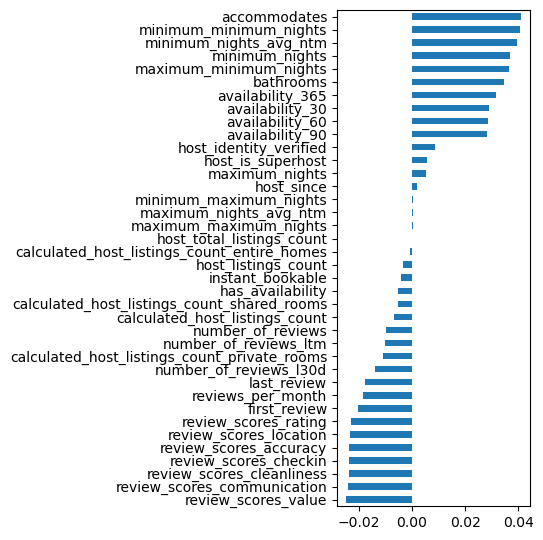

In [22]:
f = plt.figure(figsize=(5.5, 5.5))
# Get Pearson correlation between the price and features, sort
# Drop the price itself and plot horizontal bar chart
df.select_dtypes(include=np.number).corr().loc['price'].sort_values()[:-1].plot.barh()
plt.tight_layout()

The figure shows the linear correlation between each feature and the target. Let's also examine the corresponding statistical significance with alpha = 0.05 and assign correlation categories.

In [23]:
# Create a dataframe for the pearson correlations
df_pearson_price = pd.DataFrame(index=df.select_dtypes(include=np.number).drop(columns='price').columns,
                                columns=['corr', 'p_value', 'sig', 'cat'])

# Iterate over columns in the DataFrame (excluding 'price')
for col in df.drop(columns='price').columns:
    # Check if the column contains numeric data
    if is_numeric_dtype(df[col]):
        # Create a boolean mask to filter out rows with NaN values
        valid_mask = np.logical_and(~np.isnan(df[col]), ~np.isnan(df['price']))
        # Calculate Pearson correlation and p-value, considering only valid non-NaN values
        df_pearson_price.loc[col, ['corr', 'p_value']] = pearsonr(df[col][valid_mask], df['price'][valid_mask])

# Check for statistical significance with alpha = 0.05
df_pearson_price.loc[:,'sig'] = df_pearson_price['p_value']<0.05

# Define the cut points and labels for the correlation categories
cut_points = [0, 0.2, 0.4, 0.6, 0.8, 1]
labels = ['very weak', 'weak', 'moderate', 'strong', 'very strong']

# Map the values in 'corr' to the corresponding categories
df_pearson_price['cat'] = pd.cut(np.abs(df_pearson_price['corr']),
                                 bins=cut_points,
                                 labels=labels,
                                 include_lowest=True)

df_pearson_price.sort_values(by='corr', ascending=False)

,corr,p_value,sig,cat
accommodates,0.041108,0.0,True,very weak
minimum_minimum_nights,0.040643,0.0,True,very weak
minimum_nights_avg_ntm,0.039359,0.0,True,very weak
minimum_nights,0.036743,0.0,True,very weak
maximum_minimum_nights,0.03666,0.0,True,very weak
bathrooms,0.034559,0.000001,True,very weak
availability_365,0.031535,0.000006,True,very weak
availability_30,0.029061,0.000032,True,very weak
availability_60,0.028491,0.000045,True,very weak
availability_90,0.028281,0.000052,True,very weak


Before considering removing features, it is important to note that the weak correlations and statistical insignificance observed are based on Pearson's correlation, which only captures linear relationships for numeric features. Further analysis is required to assess the correlations between the features themselves, and other tests should be considered before making a decision to drop these features.

### ϕk-Correlation between features and price
The ϕk correlation captures multiple correlations and can be applied to interval, ordinal, and categorical features. See the original paper by [Baak et al.](https://arxiv.org/pdf/1811.11440.pdf) (2019, p. 12). Again, we only look at the correlation between the characteristics and the target price.

In [24]:
# Function to create a list of features of a specified data type
def get_columns_by_dtype(df: pd.DataFrame, include=None, exclude=None, include_binary=True):
    columns_of_dtype = df.select_dtypes(include, exclude).columns.tolist()
    
    if include_binary:
        columns_of_dtype = df.select_dtypes(include, exclude).columns.tolist()
    else:
        columns_of_dtype = df.select_dtypes(include, exclude).columns.tolist()
        columns_of_dtype = [col for col in columns_of_dtype if len(df[col].dropna().unique())>2]
    
    return columns_of_dtype

In [25]:
# Create empty lists to store correlations and significances
phik_correlations = []
phik_significances = []

# Get integer and float columns
num_vars = get_columns_by_dtype(df, include=np.number)

for col in df:
    # Extract column values for 'col' and 'price'
    x, y = df[[col, 'price']].T.values
    
    # Calculate phi_k correlation and significance
    if col in num_vars:
        # Calculate phi_k correlation and significance for numerical variables
        phik_correlations.append(phik.phik_from_array(x, y, num_vars=['x']))
        phik_significances.append(phik.significance.significance_from_array(x, y, num_vars=['x'])[0])
    else:
        # Calculate phi_k correlation and significance for non-numerical variables
        phik_correlations.append(phik.phik_from_array(x, y))
        phik_significances.append(phik.significance.significance_from_array(x, y)[0])

In [26]:
# Create a DataFrame with the results
df_phik_price = pd.DataFrame({'phik': phik_correlations, 'p-value': phik_significances}, index=df.columns)

# Sort the DataFrame by 'phik' column in descending order
df_phik_price.sort_values(by='phik', ascending=False, inplace=True)

# Add a new column 'significant' based on the p-value with alpha = 0.05
df_phik_price['significant'] = df_phik_price['p-value'] <= 0.05

# Sort the DataFrame by 'significant' column in ascending order, and then by 'p-value' column
df_phik_price.sort_values(by=['phik', 'significant'], ascending=False)

,phik,p-value,significant
price,1.000000,2.194365e-15,True
bathrooms,0.879722,0.000000e+00,True
accommodates,0.809016,0.000000e+00,True
property_type,0.794413,0.000000e+00,True
room_type,0.745632,0.000000e+00,True
host_total_listings_count,0.622874,9.849020e-109,True
calculated_host_listings_count,0.580972,0.000000e+00,True
availability_30,0.553955,0.000000e+00,True
minimum_minimum_nights,0.549240,3.545719e-02,True
calculated_host_listings_count_entire_homes,0.538631,0.000000e+00,True


Unlike Pearson's correlation, ϕk-values indicate some strong or very strong correlations that are statistically significant. If our goal is to model price, we are looking for features that are independent of each other but significantly correlated with price. Let's plot this coherence to visualize

array([<Axes: title={'center': '$\\Phi$-K value'}>,
       <Axes: title={'center': 'Significance'}>], dtype=object)

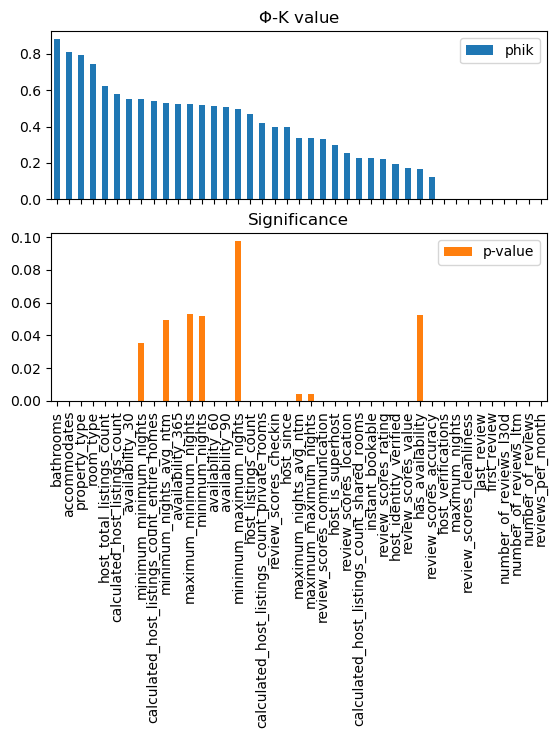

In [27]:
# Plot bar chart for 'ϕk' and 'significance' columns starting from index 1, i.e. without the price itself
df_phik_price.iloc[1:].plot.bar(subplots=True, title=[r'$\Phi$-K value', 'Significance'])

So, we should consider dropping:
- variables with correlations weaker than 0.2: *has_availability*,
 *host_identity_verified*,
 *host_verifications*,
 *maximum_nights*,
 *number_of_reviews*,
 *number_of_reviews_l30d*,
 *number_of_reviews_ltm*,
 *reviews_per_month*
- and variable that are statistically insignificant: *has_availability*,
 *maximum_nights*,
 *minimum_maximum_nights*,
 *minimum_nights*,
 *minimum_nights_avg_ntm*

In [28]:
cols_drop = [
    'has_availability',
    'host_identity_verified',
    'host_verifications',
    'maximum_nights',
    'minimum_maximum_nights',
    'minimum_nights',
    'minimum_nights_avg_ntm',
    'number_of_reviews',
    'number_of_reviews_l30d',
    'number_of_reviews_ltm',
    'reviews_per_month']

df.drop(columns=cols_drop, inplace=True)

In [29]:
print(f'Using both methods helped us to identify and drop {len(cols_drop)} weak and insignificant features.')

Using both methods helped us to identify and drop 11 weak and insignificant features.


### Pearson's correlation between all features
Now let's look at all the other Pearson's correlations. Since we are trying to find variables that are independent of each other, we need to pay special attention to feature combinations that are highly correlated. In addition, insignificant combinations, i.e. those with a p-value above a threshold alpha = 0.05, should be dropped.

In [30]:
import itertools
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
from scipy.stats import pearsonr

df_pearson_base = df.copy()
df_pearson_base = df_pearson_base.select_dtypes(include=np.number)
df_pearson_base = df_pearson_base.drop(columns='price')

# Create empty dataframes to store the Pearson's correlation and p-values
df_pearson_cor = pd.DataFrame(index=df_pearson_base.columns,
                              columns=df_pearson_base.columns,
                              dtype=float)
df_pearson_sig = df_pearson_cor.copy()

# Iterate over combinations of features
for feature1, feature2 in itertools.combinations(df.select_dtypes(include=np.number).drop(columns='price').columns, 2):
    # Check if both features are numeric
    if is_numeric_dtype(df[feature1]) and is_numeric_dtype(df[feature2]):
        # Create a boolean mask to filter out rows with NaN values
        valid_mask = np.logical_and(~np.isnan(df[feature1]), ~np.isnan(df[feature2]))
        
        # Extract the non-NaN values for each feature
        values1 = df[feature1][valid_mask]
        values2 = df[feature2][valid_mask]
        
        # Calculate Pearson's correlation and p-value, considering only valid non-NaN values
        correlation, p_value = pearsonr(values1, values2)
        
        # Store the correlation and p-value in the respective dataframes
        df_pearson_cor.loc[feature2, feature1] = correlation.astype(float)
        df_pearson_sig.loc[feature2, feature1] = p_value.astype(float)

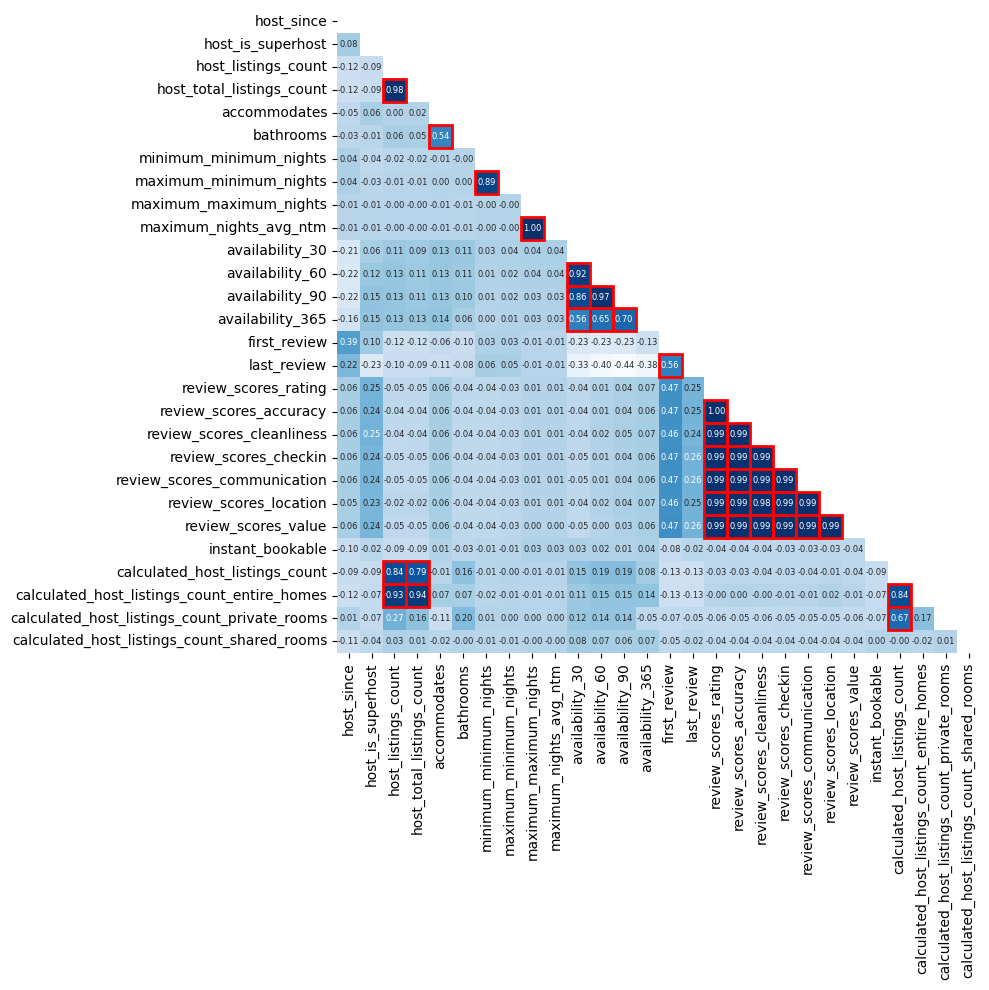

In [31]:
# Plot seaborn heatmap
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_pearson_cor,
            cmap='Blues',
            annot=True,
            fmt='.2f',
            annot_kws={'size': 6},
            cbar=False,
            ax=ax)

# Add squares to values larger than 0.5
for i in range(len(df_pearson_cor)):
    for j in range(len(df_pearson_cor.columns)):
        if df_pearson_cor.iloc[i, j] > 0.5:
            ax.add_patch(patches.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=2))

plt.tight_layout()
plt.show()

In [32]:
# Sum up Pearson's correlation > 0.5 or significance above 0.05 along both axes
sum_axis_0 = np.sum((df_pearson_cor > 0.5) | (df_pearson_sig > 0.05), axis=0)
sum_axis_1 = np.sum((df_pearson_cor > 0.5) | (df_pearson_sig > 0.05), axis=1)

# Sum up and sort in descending order
sum_all = (sum_axis_0 + sum_axis_1).sort_values(ascending=False)
sum_all

maximum_maximum_nights                          21
maximum_nights_avg_ntm                          21
maximum_minimum_nights                          13
calculated_host_listings_count_entire_homes     12
minimum_minimum_nights                          11
calculated_host_listings_count                  11
review_scores_value                             10
review_scores_communication                     10
review_scores_checkin                           10
review_scores_accuracy                          10
review_scores_rating                            10
review_scores_location                           9
review_scores_cleanliness                        9
calculated_host_listings_count_shared_rooms      8
accommodates                                     8
availability_60                                  8
calculated_host_listings_count_private_rooms     7
host_listings_count                              7
host_total_listings_count                        6
availability_365               

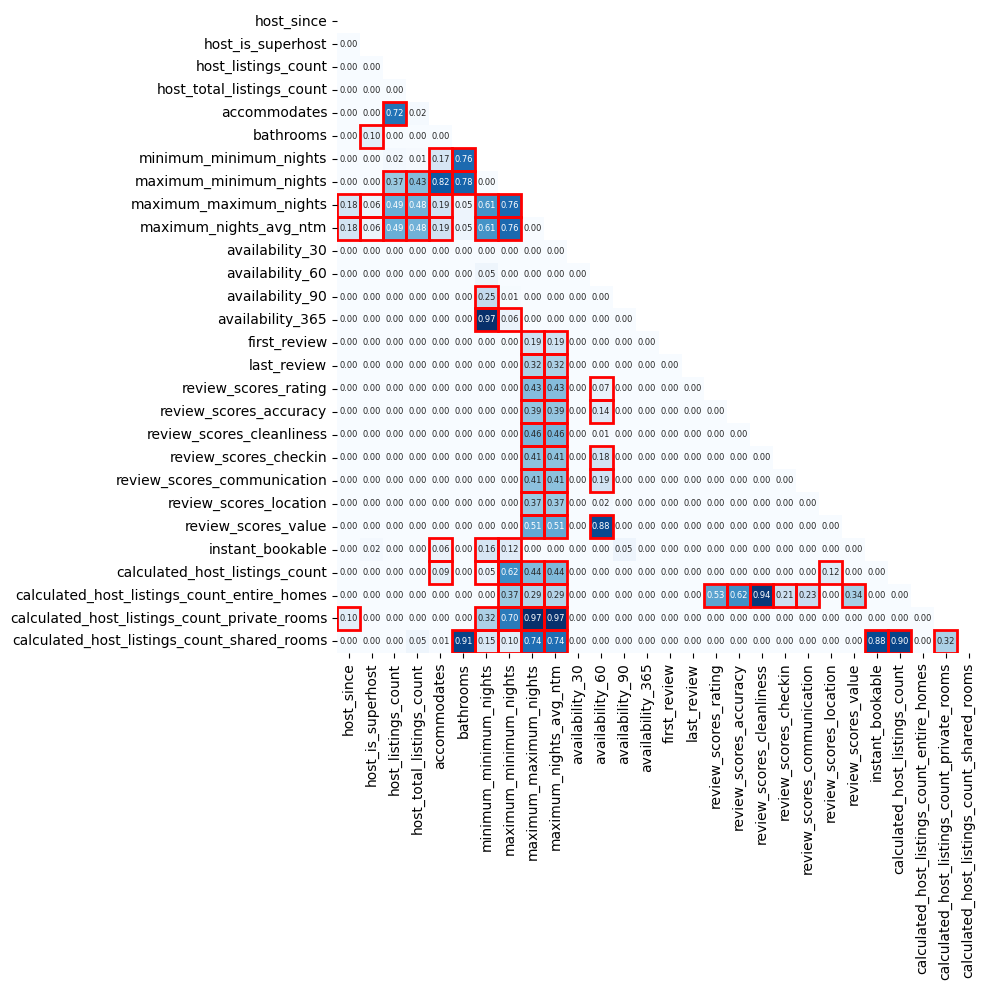

In [33]:
# Plot seaborn heatmap for significance
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_pearson_sig,
            cmap='Blues',
            annot=True,
            fmt='.2f',
            annot_kws={'size': 6},
            cbar=False,
            ax=ax)

# Add squares to values larger than 0.05
for i in range(len(df_pearson_sig)):
    for j in range(len(df_pearson_sig.columns)):
        if df_pearson_sig.iloc[i, j] > 0.05:
            ax.add_patch(patches.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=2))

plt.tight_layout()
plt.show()

In [34]:
np.sum((df_pearson_cor>0.5) | (df_pearson_sig > 0.05), axis=0) +\
np.sum((df_pearson_cor>0.5) | (df_pearson_sig > 0.05), axis=1)

host_since                                       3
host_is_superhost                                3
host_listings_count                              7
host_total_listings_count                        6
accommodates                                     8
bathrooms                                        5
minimum_minimum_nights                          11
maximum_minimum_nights                          13
maximum_maximum_nights                          21
maximum_nights_avg_ntm                          21
availability_30                                  3
availability_60                                  8
availability_90                                  4
availability_365                                 5
first_review                                     3
last_review                                      3
review_scores_rating                            10
review_scores_accuracy                          10
review_scores_cleanliness                        9
review_scores_checkin          

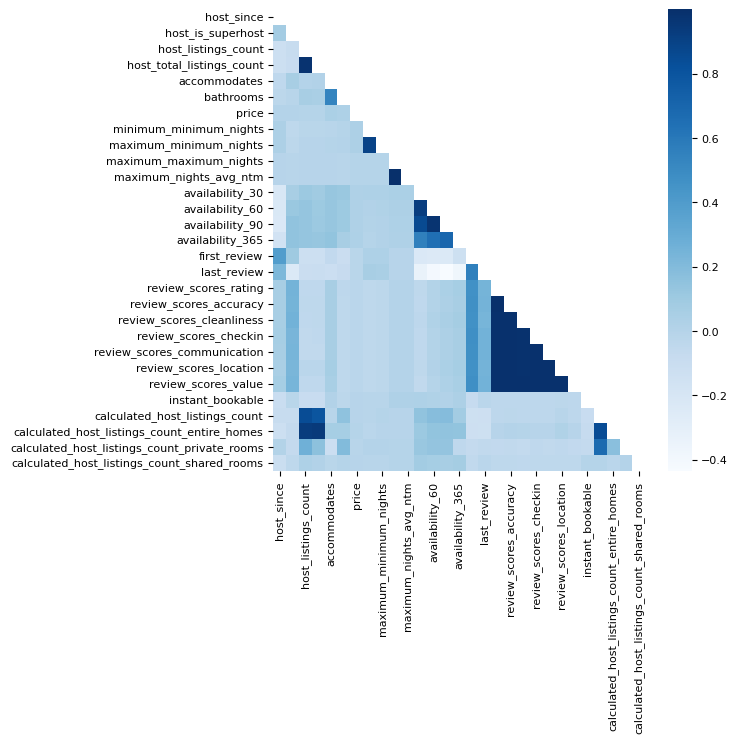

In [35]:
# Calculate correlation matrix for numerical columns
matrix = df.select_dtypes(include=np.number).corr()

# Create a boolean mask to hide the upper triangle of the matrix
mask = np.triu(np.ones_like(matrix, dtype=bool))

# Create a figure and axes for the heatmap
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the heatmap
sns.heatmap(matrix, mask=mask, ax=ax, cmap='Blues')

# Set tick label font size for both x-axis and y-axis
ax.tick_params(labelsize=8)

# Adjust the colorbar tick label font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)

The heatmap shows some strong and very strong Pearson correlations in dark blue. Let's look at all the correlations above a threshold of 0.6, i.e. at least strong correlations.

In [36]:
# Create a DataFrame of Pearson correlations for numerical columns
df_corr = df.select_dtypes(include=np.number).corr().stack().reset_index()

# Rename the columns of the correlation DataFrame
df_corr = df_corr.rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'correlation'})

# Filter out correlations between the same features
df_corr = df_corr[df_corr['feature_1'] != df_corr['feature_2']]

# Filter the correlations with correlation value greater than 0.8
df_corr = df_corr[df_corr.correlation > 0.6]

df_corr

,feature_1,feature_2,correlation
61,host_listings_count,host_total_listings_count,0.979846
83,host_listings_count,calculated_host_listings_count,0.843935
84,host_listings_count,calculated_host_listings_count_entire_homes,0.930115
89,host_total_listings_count,host_listings_count,0.979846
112,host_total_listings_count,calculated_host_listings_count,0.794080
...,...,...,...
752,calculated_host_listings_count,calculated_host_listings_count_private_rooms,0.672756
756,calculated_host_listings_count_entire_homes,host_listings_count,0.930115
757,calculated_host_listings_count_entire_homes,host_total_listings_count,0.939835
779,calculated_host_listings_count_entire_homes,calculated_host_listings_count,0.844294


The table provides guidance on which features should be eliminated, transformed, or modified in some way. Having only independent features in a machine learning model is beneficial because it reduces the risk of multicollinearity, allows for accurate interpretation of feature importance, and prevents redundancy in capturing information about the target variable.

### ϕk-Correlation between all features
ϕk is a measure of the correlation between variables. Here we look at how the features are correlated and then look at the significance. In the case of a strong correlation, i.e. close to 1 and a significance below an alpha of 0.05, we consider dropping more features.

In [37]:
# Calculate ϕk-matrix, numerical features are passed
phik_matrix = phik.phik_matrix(df, interval_cols=num_vars)
# Get the significance matrix expressed as one-sided Z
# of the hypothesis test of each variable-pair dependency
sig_matrix = phik.significance_matrix(df, interval_cols=num_vars)

The output of significance_matrix is a one-sided z-score, a statistical measure that quantifies the deviation of a data point from the mean relative to the standard deviation in a given direction. To again achieve a 95% confidence level, i.e. with alpha = 0.05, we need to look for a z-score greater than 1.64 ([Baak et al., 2019](https://arxiv.org/pdf/1811.11440.pdf)). I used this property to mask statistically insignificant ϕk correlations in a heat map. 

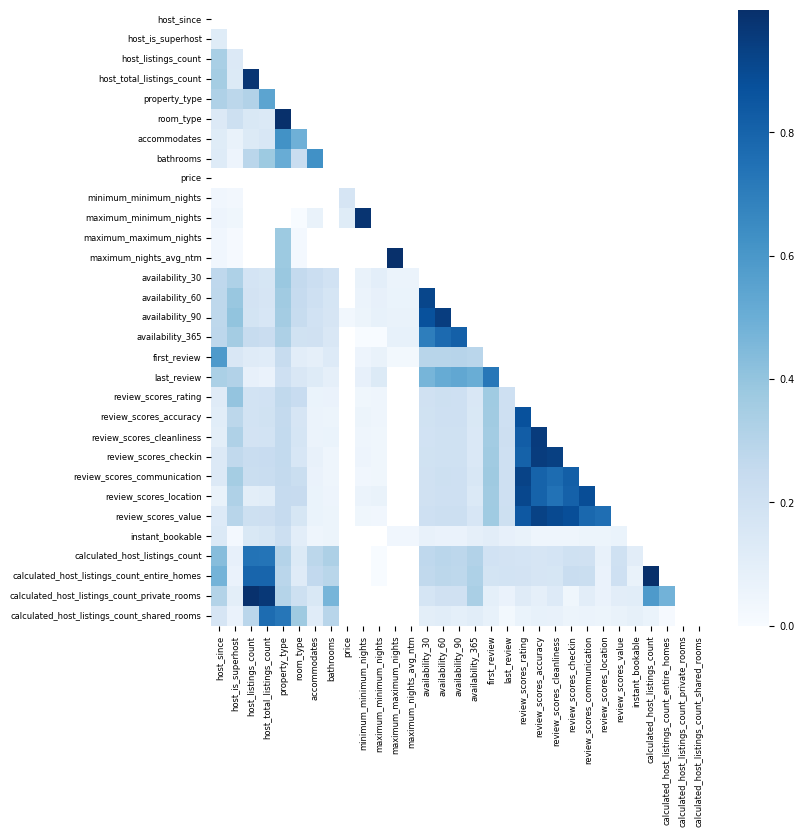

In [38]:
# Create a mask above the diagonal due to the symmetry of the matrix
mask = np.triu(np.ones_like(sig_matrix, dtype=bool))

# Add a mask for significance for alpha < 0.05, i.e. z-score > 1.64
mask = (sig_matrix < 1.64) | mask

# Create a figure and axes for the heatmap
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the heatmap
sns.heatmap(phik_matrix, mask=mask, ax=ax, cmap='Blues')

# Set tick label font size for both x-axis and y-axis
ax.tick_params(labelsize=6)

# Adjust the colorbar tick label font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=7)

In [39]:
# Create a mask for ϕk larger than 0.6 and z-score > 1.96
mask_phik_sig = np.logical_and(~mask.values, phik_matrix > 0.6, sig_matrix > 1.64)

# Mask the phik_matrix, unstack, reset its index, and drop NaN values
df_phik_z = phik_matrix[mask_phik_sig].unstack().reset_index().dropna()

# Rename the columns of the DataFrame
df_phik_z = df_phik_z.rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'phik'})

# Sort the DataFrame by 'phik' column in descending order and reset the index
df_phik_z = df_phik_z.sort_values(by='phik', ascending=False).reset_index(drop=True)

# Iterate over df_phik_z and add z-score from significance matrix
for idx, (x, y) in enumerate(zip(df_phik_z['feature_1'], df_phik_z['feature_2'])):
    df_phik_z.loc[idx, 'z_score'] = sig_matrix.loc[x, y]

# Display the resulting DataFrame
df_phik_z

,feature_1,feature_2,phik,z_score
0,property_type,room_type,0.998879,159.587847
1,maximum_maximum_nights,maximum_nights_avg_ntm,0.997858,14.153374
2,calculated_host_listings_count,calculated_host_listings_count_entire_homes,0.995277,135.764508
3,host_listings_count,calculated_host_listings_count_private_rooms,0.992510,52.119900
4,minimum_minimum_nights,maximum_minimum_nights,0.980879,36.413430
5,host_listings_count,host_total_listings_count,0.979247,85.751461
6,host_total_listings_count,calculated_host_listings_count_private_rooms,0.966893,50.008546
7,review_scores_accuracy,review_scores_cleanliness,0.953475,156.362125
8,review_scores_accuracy,review_scores_checkin,0.950207,151.630755
9,availability_60,availability_90,0.946564,227.304533


### Putting analysis results into action
In the previous section we learned a lot about the correlations between features. Now it's time to use this knowledge to improve our data. Here is a list of things we should solve:

* **Engineer new *total_capacity* feature**: *Accommodation* and *bathrooms* are highly correlated. Let's engineer *total_capacity* as their sum.

In [40]:
df['total_capacity'] = df['accommodates'] + df['bathrooms']
df = df.drop(columns=['accommodates', 'bathrooms'])

* **Engineer *review_scores_mean***: All review scores are highly correlated. Let's engineer their mean and drop the others.

In [41]:
review_scores = df.filter(like='score').columns.to_list()
df['review_scores_mean'] = np.mean(df[review_scores], axis=1)
df.drop(columns=review_scores, inplace=True)

* **Drop *property_type***: There is a strong correlation between *property_type* and *room_type*. As property_type is much more specific and is chosen by the host, 15 property types exist only once and even more only a few times. Let'drop *property_type*!

In [42]:
df.drop(columns='property_type', inplace=True)

* **Drop *counting features***: The counting features are highly correlated. Let's only keep *host_total_listings_count* and drop the others.

In [43]:
cols_count = ['calculated_host_listings_count',
              'calculated_host_listings_count_entire_homes',
              'calculated_host_listings_count_private_rooms',
              'calculated_host_listings_count_shared_rooms',
              'host_listings_count']

df.drop(columns=cols_count, inplace=True)

* **Drop *min/max night features***: The features regarding mininum or maximum nights are highly correlated an hold no valuable information. Let's drop them.

In [44]:
df.drop(columns=[col for col in df.columns if 'night' in col], inplace=True)

* **Drop *availability features***: The features concerning *availabilty* in the coming days are highly correlated. Let's only keep the one that looks one year ahead *availability_365* and *has_availability*.

In [45]:
cols_aivailability = ['availability_30', 'availability_60', 'availability_90']
df.drop(columns=cols_aivailability, inplace=True)

* **Drop *first_review***: The feature *first_review* is highly correlated with *host_since*, which we keep. It is also correlated with the above list of availability features and *last_review*. So let's drop *first_review*.

In [46]:
df.drop(columns='first_review', inplace=True)

### Check the Pearson's matrix and the ϕk-matrix again.
Here we make sure that we have achieved the desired result

In [47]:
df_corr = df.select_dtypes(include=np.number).corr().stack().reset_index()
df_corr = df_corr.rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'correlation'})
df_corr = df_corr[df_corr['feature_1'] != df_corr['feature_2']]

df_corr.sort_values(by='correlation', ascending=False).head(5)

,feature_1,feature_2,correlation
77,review_scores_mean,last_review,0.252820
53,last_review,review_scores_mean,0.252820
17,host_is_superhost,review_scores_mean,0.242782
73,review_scores_mean,host_is_superhost,0.242782
45,last_review,host_since,0.218289


In [48]:
df_corr.sort_values(by='correlation', ascending=True).head(5)

,feature_1,feature_2,correlation
41,availability_365,last_review,-0.378938
49,last_review,availability_365,-0.378938
46,last_review,host_is_superhost,-0.231111
14,host_is_superhost,last_review,-0.231111
4,host_since,availability_365,-0.160186


The head and tail of the Pearson's correlation dataframe show that we have managed to remove strong or very strong correlations in the data. Let's also check the ϕk-matrix.

<Axes: >

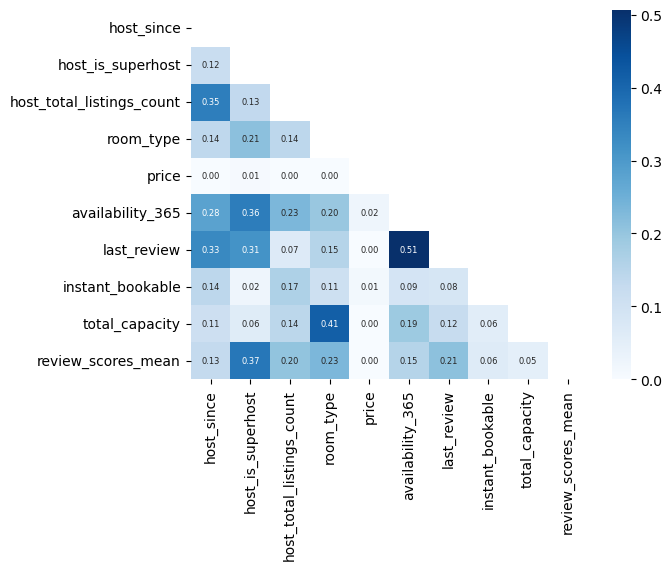

In [49]:
cols_num = get_columns_by_dtype(df, include=np.number)
phik_check = phik.phik_matrix(df, interval_cols=cols_num)
mask = np.triu(np.ones_like(phik_check, dtype=bool))
sns.heatmap(phik_check, mask=mask, annot=True, annot_kws={'size':6}, fmt='.2f', cmap='Blues')

After extensive correlation analysis, we are left with 10 features in the dataset, one of which is price.

### Variance thresholding
Variance thresholding is a technique used to remove low-variance features from a dataset in order to focus on those features that show significant variability across data points. In short, the lower the variance of a feature, the less informative it is.

In [50]:
# Create a VarianceThreshold object with a threshold of 0.03
vt = VarianceThreshold(threshold=0.03)

# Select the numerical columns from the DataFrame
numerical_columns = df.select_dtypes(include=np.number)

# Normalize the numerical columns by dividing by their mean
normalized_data = numerical_columns / numerical_columns.mean()

# Fit the VarianceThreshold to the normalized data
_ = vt.fit(normalized_data)

# Get the mask of low-variance features (features with variance below the threshold)
low_variance_mask = ~vt.get_support()

# Get the column names of the low-variance features
low_variance_features = numerical_columns.columns[low_variance_mask].to_list()
low_variance_features

[]

The mean of the review scores has low variance and thus holds little information. The feature could also be dropped.

In [51]:
df.drop(columns=low_variance_features, inplace=True)

This is the end of the correlation analysis and variance thresholding. The combination of the methods allowed us to drop 37 features from the initial 48. The next steps are necessary to continue training a model and are not explicitly mentioned in my article on [medium.com](https://medium.com/@romanwolf_22352/what-drives-the-price-of-an-airbnb-9f17019954d4).

### Handling outliers in target with mean absolute deviation
This visualization step is specific to one dataset because it focuses on the target variable, which was not modified during the feature selection process.

In [52]:
# list with df with and without feature selection
list_df = [df, df_no_selection]

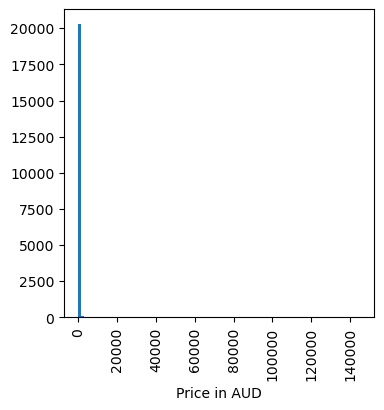

In [53]:
def plot_histogram_price(df=pd.DataFrame, target='price'):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.hist(df['price'], bins=100)
    ax.set_xlabel('Price in AUD')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xticks(rotation=90)
    plt.show()

# Plot the histogram
plot_histogram_price(df)

In [54]:
# Get descriptive statistics
list_df[0]['price'].describe()

count     20486.000000
mean        289.119740
std        2460.002477
min           0.000000
25%          99.000000
50%         160.000000
75%         250.000000
max      145160.000000
Name: price, dtype: float64

The histogram and descriptive statistics show that there must be outliers in the target feature. As the feature is not normally distributed, we use the mean absolute deviation to identify outliers and remove them from the data set.

In [55]:
def print_percentage_outlier(labels):
    unique_elements, counts = np.unique(labels, return_counts=True)
    percentage_outlier = round(counts[1]/len(labels)*100, 2)
    return print(f'{percentage_outlier}% of the price are deleted as outliers')

def get_MAD_labels(df, target='price'):
    """
    Computes the labels for inliers based on Median Absolute Deviation (MAD).

    Args:
        df (pd.DataFrame): The DataFrame containing the target variable.
        target (str): The name of the target variable column in the DataFrame.

    Returns:
        np.ndarray: An array of boolean labels indicating the inliers.
    """
    target_values = df[target].values
    mad = MAD().fit(target_values.reshape(-1, 1))

    # Extract the inlier/outlier labels
    labels = mad.labels_
    labels_inlier = labels == 0
    
    print_percentage_outlier(labels)
    
    return labels_inlier

In [56]:
# Iterate over the list and drop outliers
for i in range(len(list_df)):
    df_temp = list_df[i]
    
    # Get labels for inliers using MAD
    labels_inlier = get_MAD_labels(df_temp, 'price')
    
    # Filter DataFrame to keep only inliers
    df_temp = df_temp[labels_inlier]
    
    # Update the DataFrame in the list
    list_df[i] = df_temp

6.14% of the price are deleted as outliers
6.14% of the price are deleted as outliers


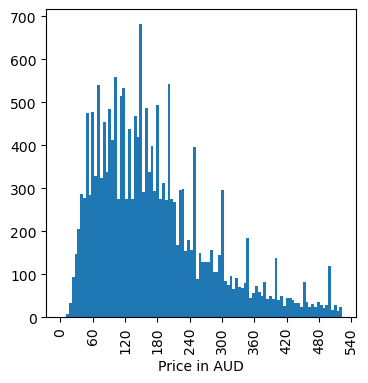

In [57]:
# Plot a histogram of the price again
plot_histogram_price(list_df[0])

## Visually inspect skew of features

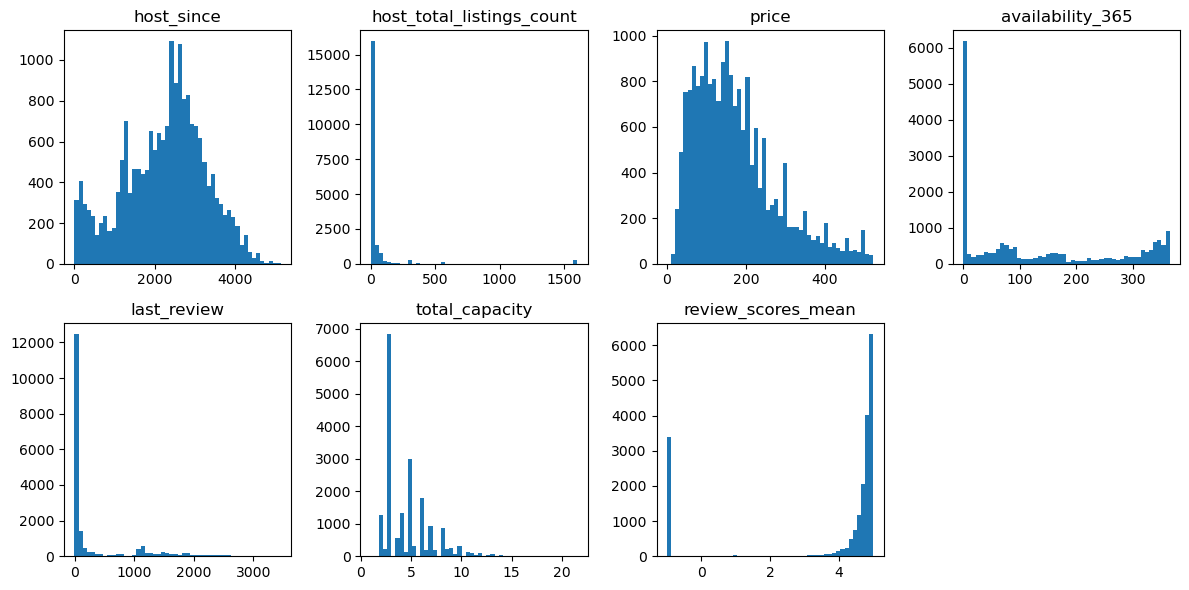

In [58]:
non_binary_numeric_columns = get_columns_by_dtype(list_df[0], include=np.number, include_binary=False)

len_num_cols = len(non_binary_numeric_columns)
cols = 4
rows = (len_num_cols - 1) // cols + 1

fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

for i, col in enumerate(non_binary_numeric_columns):
    ii, ij = i // cols, i % cols
    ax[ii, ij].hist(list_df[0][col], bins=50)
    ax[ii, ij].set_title(col)

# Remove empty subplots
if len_num_cols % cols != 0:
    for j in range(len_num_cols % cols, cols):
        fig.delaxes(ax[rows - 1, j])

plt.tight_layout()
plt.show()

## Visually inspect after applying power transformation

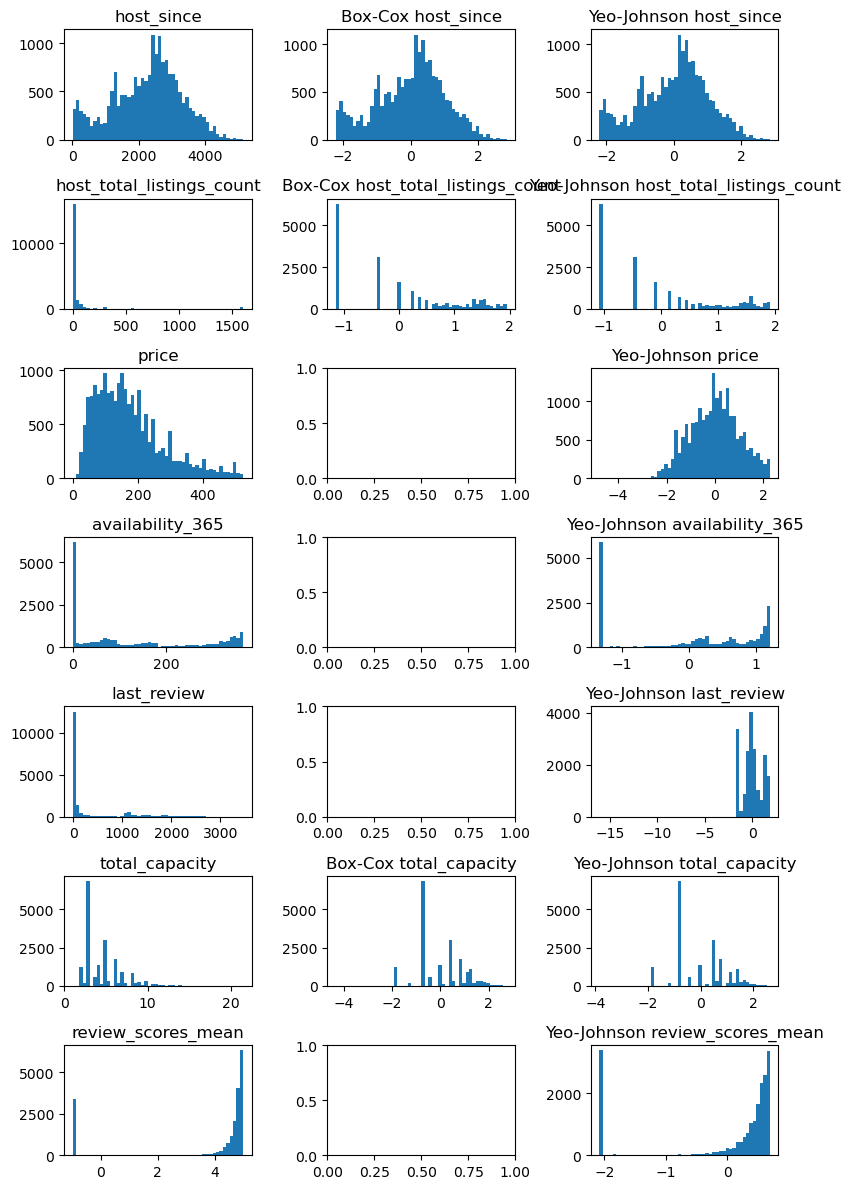

In [59]:
pt = PowerTransformer()

cols = get_columns_by_dtype(list_df[0], include=np.number, include_binary=False)

fig, ax = plt.subplots(len(cols), 3, figsize=(8, 12))

for i, col in enumerate(cols):
    ax[i, 0].hist(list_df[0][col], bins=50)
    ax[i, 0].set_title(col)

    # Transform with Box-Cox for purely positive features
    if all(x > 0 for x in list_df[0][col]):
        pt.set_params(method='box-cox')

        data = pt.fit_transform(list_df[0][col].values.reshape(-1, 1))

        ax[i, 1].hist(data, bins=50)
        ax[i, 1].set_title('Box-Cox '+col)

    # Transform with Yeo-Johnson
    pt.set_params(method='yeo-johnson')

    data = pt.fit_transform(list_df[0][col].values.reshape(-1, 1))

    ax[i, 2].hist(data, bins=50)
    ax[i, 2].set_title('Yeo-Johnson '+col)

plt.tight_layout()
plt.show()

### Write a function to select best power transformation method
This function tests whether the absolute skewness is greater than 0.5 and tests
* a) Box-Cox transformation for all positive features
* b) Yeo-Johnson transformation for everything else

and compares the skew results, selects the one that results in less skew, fit_transforms the feature and appends to a transformed DataFrame which it finally returns.

In [60]:
def pickle_dump(file_name, variable):
    with open(file_name, 'wb') as file:
        pickle.dump(variable, file)

def feature_skew_above_threshold(df=pd.DataFrame, threshold=float, columns=[]):
    """
    Identifies columns with skewness above a specified threshold in a DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        threshold (float): The skewness threshold value.
        columns (list): List of columns to check.
    
    Returns:
        list: List of columns with skewness above the threshold.
    """
    columns_above_threshold = [col for col in columns if np.abs(skew(df[col])) > threshold]
    return columns_above_threshold


def test_skew_reduction_methods(df=pd.DataFrame, columns=[]):
    """
    Tests and applies the skewness reduction methods Box-Cox and Yeo-Johnson to columns in a DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame to transform.
        columns (list): List of columns to transform.
    
    Returns:
        tuple: A tuple containing the transformed DataFrame and a dictionary
            with the skew reduction method for each column.
    """
    pt = PowerTransformer()
    dict_skew = {col: None for col in columns}
    df_transformed = pd.DataFrame()

    for col in columns:
        col_reshaped = df[col].values.reshape(-1, 1)
        skew_box_cox, skew_yeo_johnson = np.nan, np.nan

        if all(x > 0 for x in df[col]):
            pt.set_params(method='box-cox')
            data = pt.fit_transform(col_reshaped)
            skew_box_cox = np.abs(skew(data))

        pt.set_params(method='yeo-johnson')
        data = pt.fit_transform(col_reshaped)
        skew_yeo_johnson = np.abs(skew(data))

        if (skew_box_cox < skew_yeo_johnson) or not skew_box_cox:
            dict_skew[col] = 'box-cox'
            pt.set_params(method='box-cox')
            df_transformed[col] = pt.transform(col_reshaped).flatten()
        else:
            dict_skew[col] = 'yeo-johnson'
            pt.set_params(method='yeo-johnson')
            df_transformed[col] = pt.transform(col_reshaped).flatten()
        
        if col == 'price':
            pickle_dump('power_transformer.pkl', pt)
            
    return df_transformed, dict_skew

In [61]:
for i, df_temp in enumerate(list_df):
    df_temp.reset_index(inplace=True, drop=True)
    
    # Get the non-binary numeric columns
    non_binary_numeric_columns = get_columns_by_dtype(df_temp, exclude='category', include_binary=False)
    
    # Get the list of features with medium skewness
    list_features_medium_skew = feature_skew_above_threshold(df_temp, 0.5, non_binary_numeric_columns)
    
    # Apply skewness reduction methods and get the transformed dataframe and dictionary
    df_temp_transformed, dict_skew = test_skew_reduction_methods(df_temp, list_features_medium_skew)
    
    # Update the original dataframe with the transformed features
    df_temp.loc[:, list_features_medium_skew] = df_temp_transformed

    # Save the dictionary with applied method to a pickle file
    pickle_dump(f'dict_skew_{i}.pkl', dict_skew)
        
    # Update the dataframe in the list
    list_df[i] = df_temp

## Encode categoricals
Although some of the models I want to test also work with categorical data, I use one-hot encoding for the other models so that they can work with the data as well. I didn't do this earlier because I wanted to do the ϕk-correlation analysis first.

In [62]:
def map_unique_values(df: pd.DataFrame, col='column to be mapped'):
    """
    Maps the unique values of a specified column in a DataFrame to consecutive integers.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the column to be mapped.
        col (str): The name of the column to be mapped.
    
    Returns:
        pd.Series: A new Series with the mapped values.
    """
    unique_items = df[col].dropna().unique()
    map_dict = {item: i for i, item in enumerate(unique_items)}
    return df[col].map(map_dict).astype('category')

for i, df_temp in enumerate(list_df):
    
    # Map the unique values of a specified column to consecutive integers
    cols_cat = get_columns_by_dtype(df_temp, include='category') 
    for col in cols_cat:
        df_temp.loc[:, col] = map_unique_values(df_temp, col)
        
    # Instantiate OneHotEncoder and fit_transform
    ohe = OneHotEncoder(sparse_output=False, drop='first')
    encoded_data = ohe.fit_transform(df_temp[cols_cat])
    
    # Add encoded data to df_temp and drop cols_cat
    df_temp.reset_index(drop=True, inplace=True)
    df_temp.loc[:, ohe.get_feature_names_out(cols_cat)] = encoded_data
    df_temp = df_temp.drop(columns=cols_cat)
    
    # Update the dataframe in the list
    list_df[i] = df_temp

In [63]:
for i in [0,1]:
    df = list_df[i]
    assert df.isnull().sum().sum() == 0, "There are missing values in the DataFrame"

## Scale the data
When features have different scales or sizes, they need to be standardised. Scaling features with <mark>StandardScaler</mark> subtracts the mean and divides by the standard deviation to standardise the data. This ensures consistent scaling of all features, which is important for many ML algorithms. <mark>StandardScaler</mark> makes it easier to compare the importance of features, avoids bias towards large features, and improves the performance and convergence of ML models.

I tested MinMaxScaler, RobustScaler, and StandarScaler from sklearn, of which the last one produced the best final results in terms of mean absolute error of the model. So I decided to use the StandardScaler.

In [64]:
scaler = StandardScaler()

for i, df_temp in enumerate(list_df):
    # leave target untouched
    target = df_temp['price'].reset_index(drop=True)
    arr_scaled = scaler.fit_transform(df_temp.drop(columns='price'))

    df_scaled = pd.DataFrame(arr_scaled, columns=df_temp.drop(columns='price').columns)
    df_scaled['price']=target
    
    # Update the dataframe in the list
    list_df[i] = df_temp

# IV. Data Modeling <a id="modeling"></a>
## Test several models <a id="test_several_models"></a>
I opted to evaluate multiple models using their default settings and select the ones that yield the lowest mean absolute error (MAE). I chose the models with the lowest MAE because it indicates the average absolute difference between the predicted values and the actual target values.

In [65]:
# Function to load pickle
def pickle_load(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

In [66]:
models = [
    BayesianRidge(),
    ElasticNet(),
    GradientBoostingRegressor(),
    LGBMRegressor(),
    LinearRegression(),
    RandomForestRegressor(),
    XGBRegressor()
              ]

# Load power transformer
pt = pickle_load('power_transformer.pkl')

dataset_names = ['Dataset with feature selection', 'Dataset without feature selection']

for i, df_temp in enumerate(list_df):
    line = '-' * 60
    print(f'\n{line}\n\033[1m{dataset_names[i]}\033[0m')
    
    X_train, X_test, y_train, y_test = train_test_split(df_temp.drop(columns='price'),
                                                        df_temp['price'],
                                                        test_size=0.2,
                                                        random_state=42)

    # Inverse transform y_test due to previous  power tranformation
    y_test = pt.inverse_transform(y_test.values.reshape(-1, 1))
    
    score_dict = {model.__class__.__name__: {'rmse': None, 'mae': None} for model in models}
    lowest_mae = float('inf')  # Initialize the lowest MAE as positive infinity
    best_model_y_pred = None
    best_model_y_test = None
    
    for model in models:
        model_name = model.__class__.__name__

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Inverse-transform y_pred as well
        y_pred = pt.inverse_transform(y_pred.reshape(-1, 1))

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        score_dict[model_name]['rmse'] = rmse
        score_dict[model_name]['mae'] = mae

        # Check if the current model has the lowest MAE
        if mae < lowest_mae:
            lowest_mae = mae
            best_model_y_pred = y_pred
            best_model_y_test = y_test

        file_name = ('testing_'+dataset_names[i]+'.pkl').lower().replace(' ', '_')
        pickle_dump(file_name, score_dict)
        
        print(f'{model_name : <25} RMSE: {rmse : .4f}{"":<5} MAE: {mae : .4f}')

        # Stack the arrays side by side using numpy.column_stack()
        stacked_data = np.column_stack((best_model_y_pred, best_model_y_test))
        file_name = dataset_names[i].lower().replace(' ', '_')
        
        # Save the stacked data to a CSV file
        np.savetxt(f'scatter_data_{file_name}.csv', stacked_data, delimiter=',')


------------------------------------------------------------
Dataset with feature selection
BayesianRidge             RMSE:  76.3998      MAE:  53.1619
ElasticNet                RMSE:  95.5215      MAE:  69.7505
GradientBoostingRegressor RMSE:  69.5422      MAE:  47.5239
LGBMRegressor             RMSE:  66.5678      MAE:  44.9505
LinearRegression          RMSE:  76.3974      MAE:  53.1615
RandomForestRegressor     RMSE:  68.5617      MAE:  46.0282
XGBRegressor              RMSE:  67.1638      MAE:  45.0616

------------------------------------------------------------
Dataset without feature selection
BayesianRidge             RMSE:  69.9783      MAE:  47.8403
ElasticNet                RMSE:  89.7992      MAE:  63.5114
GradientBoostingRegressor RMSE:  65.3542      MAE:  43.8877
LGBMRegressor             RMSE:  61.6726      MAE:  40.9672
LinearRegression          RMSE:  69.8963      MAE:  47.7725
RandomForestRegressor     RMSE:  63.2717      MAE:  42.2168
XGBRegressor              RMSE:

## Select top 3 models<a id='select-top3'></a>
Here, I create a dictionary that sorts the results of the tested models based on their mean absolute error (MAE). Again for both datasets.

In [67]:
# iterate over previously saved score_dicts of both datasets
for i, file_name in enumerate(glob.glob('testing*')[::-1]):
    
    score_dict = pickle_load(file_name)
    
    # Sort the models based on MAE values in ascending order
    sorted_models = sorted(score_dict.items(), key=lambda x: x[1]['mae'])
    # Extract the lowest three models and their corresponding MAE values
    lowest_three = dict(sorted_models[:3])
    # Create a new dictionary containing only the MAE values of the lowest three models
    mae_dict = {model: values['mae'] for model, values in lowest_three.items()}
    
    line = '-' * 41
    print(f'\n{line}\n\033[1mMAE of {dataset_names[i]}\033[0m')
    for key, item in mae_dict.items():
        print(f'{key : <28}: {item : .2f}')


-----------------------------------------
MAE of Dataset with feature selection
LGBMRegressor               :  44.95
XGBRegressor                :  45.06
RandomForestRegressor       :  46.03

-----------------------------------------
MAE of Dataset without feature selection
LGBMRegressor               :  40.97
XGBRegressor                :  41.08
RandomForestRegressor       :  42.22


## Score and plot learning curves of top 3 models <a id="score_plot_learning_curves_top_3"></a>
In this step, I used the learning_curve method from sklearn along with cross-validation and the inverse_mae_scorer to analyze whether there is overfitting or underfitting in any of the top 3 models.

In [68]:
# Create a custom scorer with inverse transformation
def inverse_mae_scorer(y_true, y_pred):
    """This scorer first inverts both y-values and then scores the MAE."""
    pt = pickle_load('power_transformer.pkl')
        
    y_true_inverse = pt.inverse_transform(y_true.values.reshape(-1, 1))
    y_pred_inverse = pt.inverse_transform(y_pred.reshape(-1, 1))
    
    # Calculate the score using the inverse transformed predictions and true values
    mae = mean_absolute_error(y_true_inverse, y_pred_inverse)
    return mae

# Make the custom scorer
inverse_mae_scorer = make_scorer(inverse_mae_scorer)


def calculate_learning_curves_with_scores(X, y, name):
    # Define the models to evaluate
    models = [LGBMRegressor(), XGBRegressor(), RandomForestRegressor()]

    # Dictionary to store the scores
    score_dict = {}

    # Iterate over the models
    for i, model in enumerate(models):
        # Get the model name
        model_name = model.__class__.__name__

        # Define the training set sizes
        train_sizes = np.linspace(0.1, 1.0, 10)

        # Compute the learning curve for the model
        train_sizes, train_scores, test_scores = learning_curve(
            estimator=model,
            X=X,
            y=y,
            train_sizes=train_sizes,
            cv=5,
            scoring=inverse_mae_scorer,
            shuffle=True
        )

        # Compute the mean and standard deviation of the scores
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        # Save the scores in the dictionary
        score_dict[model_name] = {
            'train_sizes': train_sizes,
            'train_mean': train_mean,
            'test_mean': test_mean,
            'train_std': train_std,
            'test_std': test_std
        }
        
        name = name.lower().replace(' ', '_')
        pickle_dump(f'score_dict_{name}.pkl', score_dict)
    return score_dict

In [69]:
for i, df_temp in enumerate(list_df):
    name = dataset_names[i]
    X, y = df_temp.drop(columns='price'), df_temp['price']
    calculate_learning_curves_with_scores(X, y, name)

In [70]:
def plot_learning_curves(score_dict=dict, name_dataset=str):
    '''
    Plot learning curves from a score dictionary with an overarching title.

    Args:
        score_dict (dict): Dictionary containing the learning curve scores.
        name_dataset (str): Name of the dataset for the title of the plot.
    '''
    
    n_plots = len(score_dict)
    fig, ax = plt.subplots(1, n_plots, figsize=(4*n_plots, 4), sharey=True)
    
    # Add a overarching title to the figure, set x position in pixels
    fig.suptitle(name_dataset, x=0.05, y=0.95, ha='left', fontsize=16, transform=fig.transFigure)
    
    for i, model in enumerate(score_dict):
        train_sizes = score_dict[model]['train_sizes']
        train_mean = score_dict[model]['train_mean']
        test_mean = score_dict[model]['test_mean']
        train_std = score_dict[model]['train_std']
        test_std = score_dict[model]['test_std']

        ax[i].plot(train_sizes, train_mean, label='Training MAE')
        ax[i].plot(train_sizes, test_mean, label='Validation MAE')
        ax[i].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
        ax[i].fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
        ax[i].set_xlabel('Training Set Size')
        ax[i].set_ylabel('MAE')
        #ax[i].set_ylim(0,90)
        ax[i].set_title(f'Learning curve {model}', loc='left')
        ax[i].legend(loc='best')
        ax[i].grid(True)
    
    plt.tight_layout()
    
    return fig

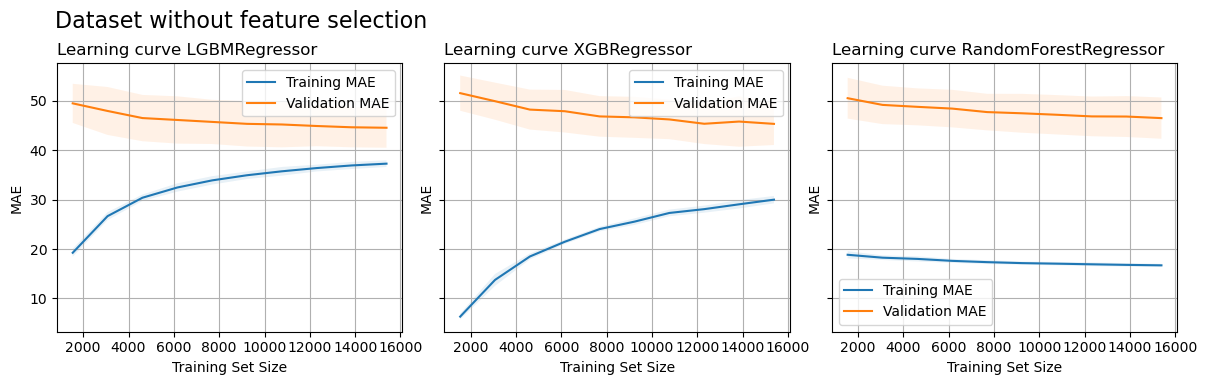

In [71]:
score_dict = pickle_load('score_dict_dataset_without_feature_selection.pkl')
plot_learning_curves(score_dict, dataset_names[1])
plt.show()

The learning curves illustrate the relationship between the size of the training set and the performance of the model. The training curves of the LGBM and XGB regressors both rise with increasing training set size with little to no variation. The curves are below the validation curves, which decrease slowly with some variation in the data. The gap between the validation and training curves is smallest for the LGBM regressor. For the Random Forest regressor, the training curve is again below the validation curve with the largest gap between them of all 3 models. The curves of all models indicate overfitting.

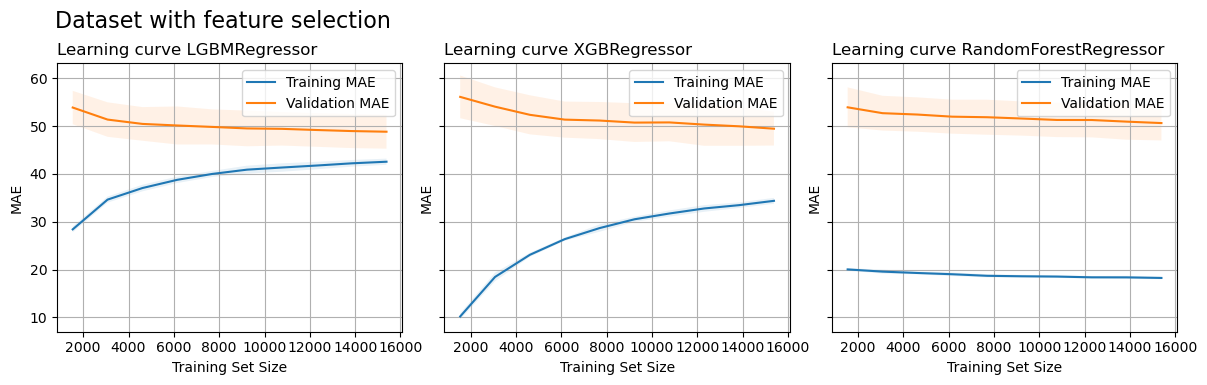

In [72]:
score_dict = pickle_load('score_dict_dataset_with_feature_selection.pkl')
plot_learning_curves(score_dict, dataset_names[0])
plt.show()

The learning curves show a similar pattern as in the first data set, except that the three models for the data set without feature selection reach a lower MAE as the training set size increases. Again, overfitting is an issue. Feature selection for default model selection does not improve model performance in terms of the issue of overfitting.

**Answer**: The default models of both datasets, i.e. with and without feature selection, indicate overfitting. They don't generalize well and perform poorly on unseen data.

## Tune LGMBRegressor with Optuna <a id='model-tuning'></a>
To address the issue of overfitting in the LGBM Regressor, a range of parameters can be tuned. By leveraging [Optuna](https://optuna.readthedocs.io/en/stable/), an objective function is defined with a parameter grid that is optimized to find the best combination of parameters.

In [ ]:
# Disable UserWarning of Optuna
warnings.filterwarnings("ignore", category=UserWarning, module="optuna")

# Define the objective function for optimization
def objective(trial, X, y, return_info=False):
    # Define the parameter grid for LightGBM
    param_grid = {
        'objective': 'regression',
        'metric': 'l1', #L1 loss, i.e. mean absolute error (MAE)
        
        #'n_estimators': trial.suggest_int('n_estimators', 100, 10000, step=100),
        #'num_boost_round': trial.suggest_int('num_boost_round', 100, 10000, step=100),
        #'n_estimators': trial.suggest_categorical('n_estimators', [10000]),

        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 3000, step=20),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        #'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 200, 10000, step=100),
        'min_child_samples': trial.suggest_int('min_child_samples', 200, 10000, step=100),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        #'lambda_l1': trial.suggest_int('lambda_l1', 0, 100, step=5),
        'reg_alpha': trial.suggest_int('reg_alpha', 0, 100, step=5),
        #'lambda_l2': trial.suggest_int('lambda_l2', 0, 100, step=5),
        'reg_lambda': trial.suggest_int('reg_lambda', 0, 100, step=5),
        #'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
        'min_split_gain': trial.suggest_float('min_split_gain', 0, 15),
        #'bagging_fraction': trial.suggest_float('bagging_fraction', 0.2, 0.9, step=0.1),
        'subsample': trial.suggest_float('subsample', 0.2, 0.9, step=0.1),
        #'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.9, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 0.9, step=0.1),
        'verbose': -1
    }  
    
    # Define cross-validation settings
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Array to store MAE scores
    cv_scores_mae = np.empty(5)

    # Perform cross-validation
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # make model globally available
        global model
        
        # Create dataset for LightGBM
        lgb_train = lgbm.Dataset(X_train, y_train, params={'verbose': -1}, free_raw_data=False)
        lgb_eval = lgbm.Dataset(X_test, y_test, params={'verbose': -1}, free_raw_data=False, reference=lgb_train)

        # Set up callbacks for early stopping and pruning
        callbacks = [
            LightGBMPruningCallback(trial, 'l1'),  # Pruning based on trial and evaluation metric
            lgbm.early_stopping(50, verbose=False)  # Early stopping with patience of 50 rounds
        ]

        model = lgbm.train(
            param_grid,
            lgb_train,
            valid_sets=[lgb_eval],  # Evaluation datasets
            callbacks=callbacks  # Callbacks for early stopping and pruning
                 )
        
        # Perform prediction
        y_pred = model.predict(X_test)
        
        pt = pickle_load('power_transformer.pkl')
        
        # inverse_transform due to power transformation of price
        y_test = pt.inverse_transform(y_test.values.reshape(-1, 1))
        y_pred = pt.inverse_transform(y_pred.reshape(-1, 1))
        
        # Calculate MAE
        mae = mean_absolute_error(y_test, y_pred)
        
        cv_scores_mae[idx] = mae

    return np.mean(cv_scores_mae)


optuna.logging.set_verbosity(optuna.logging.CRITICAL)

for i, df_temp in enumerate(list_df):
    # Create an Optuna study for optimization
    study = optuna.create_study(direction='minimize', study_name="LGBM Regressor")

    # Define the objective function for Optuna
    func = lambda trial: objective(trial, df_temp.drop(columns='price'), df_temp['price'])

    line = '-' * 90
    print(f'\n{line}\n\033[1m{dataset_names[i]}\033[0m')
    
    # Perform optimization
    study.optimize(func, n_trials=500, show_progress_bar=True)

In [73]:
# Disable UserWarning of Optuna
warnings.filterwarnings("ignore", category=UserWarning, module="optuna")

# Define the objective function for optimization
def objective(trial, X, y, return_info=False):
    # Define the parameter grid for LightGBM
    param_grid = {
        'objective': 'regression',
        'metric': 'l1', #L1 loss, i.e. mean absolute error (MAE)
        #'n_estimators': trial.suggest_int('n_estimators', 100, 10000, step=100),
        'n_estimators': trial.suggest_categorical('n_estimators', [10000]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 3000, step=20),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        #'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 200, 10000, step=100),
        'min_child_samples': trial.suggest_int('min_child_samples', 200, 10000, step=100),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        #'lambda_l1': trial.suggest_int('lambda_l1', 0, 100, step=5),
        'reg_alpha': trial.suggest_int('reg_alpha', 0, 100, step=5),
        #'lambda_l2': trial.suggest_int('lambda_l2', 0, 100, step=5),
        'reg_lambda': trial.suggest_int('reg_lambda', 0, 100, step=5),
        #'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
        'min_split_gain': trial.suggest_float('min_split_gain', 0, 15),
        #'bagging_fraction': trial.suggest_float('bagging_fraction', 0.2, 0.9, step=0.1),
        'subsample': trial.suggest_float('subsample', 0.2, 0.9, step=0.1),
        #'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.9, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 0.9, step=0.1),
        'verbose': -1
    }  
    
    # Define cross-validation settings
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Array to store MAE scores
    cv_scores_mae = np.empty(5)

    # Perform cross-validation
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # make model globally available
        global model
        
        # Initialize the LightGBM model
        model = lgbm.LGBMRegressor(**param_grid)

        # Create dataset for LightGBM
        #lgb_train = lgbm.Dataset(X_train, y_train, params={'verbose': -1}, free_raw_data=False)
        #lgb_eval = lgbm.Dataset(X_test, y_test, params={'verbose': -1}, free_raw_data=False, reference=lgb_train)

        # Fit the model with early stopping and pruning
        model.fit(X_train, y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric='l1',
                  callbacks=[LightGBMPruningCallback(trial, 'l1'),
                             lgbm.early_stopping(50, verbose=False)]
                 )        
        
        # Perform prediction
        y_pred = model.predict(X_test)
        
        pt = pickle_load('power_transformer.pkl')
        
        # inverse_transform due to power transformation of price
        y_test = pt.inverse_transform(y_test.values.reshape(-1, 1))
        y_pred = pt.inverse_transform(y_pred.reshape(-1, 1))
        
        # Calculate MAE
        mae = mean_absolute_error(y_test, y_pred)
        
        cv_scores_mae[idx] = mae

    return np.mean(cv_scores_mae)

In [74]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

for i, df_temp in enumerate(list_df):
    # Create an Optuna study for optimization
    study = optuna.create_study(direction='minimize', study_name="LGBM Regressor")

    # Define the objective function for Optuna
    func = lambda trial: objective(trial, df_temp.drop(columns='price'), df_temp['price'])

    line = '-' * 90
    print(f'\n{line}\n\033[1m{dataset_names[i]}\033[0m')
    
    # Perform optimization
    study.optimize(func, n_trials=500, show_progress_bar=True)   
    
    # Get features, parameters and MAE
    features = list_df[i].columns
    parameters = study.best_params
    result_mae = study.best_value
    
    dataset_name = dataset_names[i].lower().replace(' ', '_')

    # Save features, parameters and mae as pickle   
    pickle_dump(f'best_model_{dataset_name}_features.pkl', features)
    pickle_dump(f'best_model_{dataset_name}_parameters.pkl', parameters)
    pickle_dump(f'best_model_{dataset_name}_mae.pkl', result_mae)
    


------------------------------------------------------------------------------------------
Dataset with feature selection


  0%|          | 0/500 [00:00<?, ?it/s]


------------------------------------------------------------------------------------------
Dataset without feature selection


  0%|          | 0/500 [00:00<?, ?it/s]

## Re-run the learning curve with cross validation for the LGBM regressor
In order to assess the impact of tuning on reducing overfitting, I decided to re-run the learning curve using the parameters obtained from the Optuna study. This allowed me to evaluate whether the tuning had any significant effect on mitigating overfitting.

In [75]:
def learning_curve_with_mae_calculation(X, y, parameters, dataset_name):
    score_dict = {}

    # Define the training set sizes
    train_sizes = np.linspace(0.1, 1.0, 10)

    # Compute the learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=LGBMRegressor(**parameters),
        X=X,
        y=y,
        train_sizes=train_sizes,
        cv=5,
        scoring=inverse_mae_scorer,
        shuffle=True
    )

    # Compute the mean and standard deviation of the scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Save the scores in the dictionary
    score_dict['LGBMRegressor'] = {
        'train_sizes': train_sizes,
        'train_mean': train_mean,
        'test_mean': test_mean,
        'train_std': train_std,
        'test_std': test_std
    }
    
    dataset_name = dataset_name.lower().replace(' ', '_')
    
    pickle_dump(f'score_dict_learning_curve_{dataset_name}.pkl', score_dict)

In [76]:
for i, df_temp in enumerate(list_df):
    # Load parameters
    parameters = pickle_load(glob.glob('*parameters*')[i])
    
    learning_curve_with_mae_calculation(df_temp.drop(columns='price'),
                                         df_temp['price'],
                                         parameters,
                                         dataset_names[i])

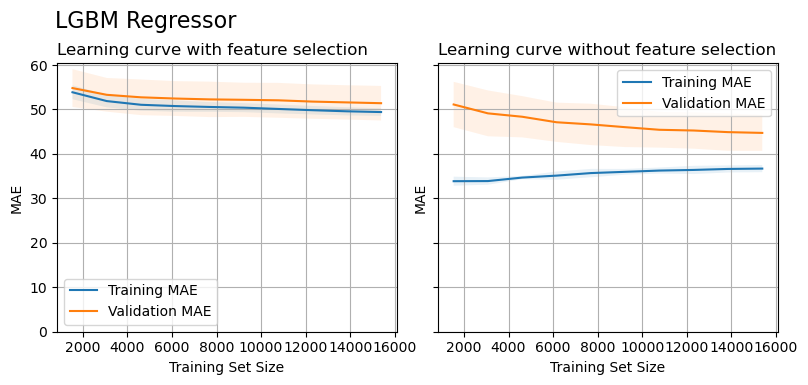

In [77]:
# Load the score_dict from the pickle files using the function
score_dict1 = pickle_load('score_dict_learning_curve_dataset_with_feature_selection.pkl')
score_dict2 = pickle_load('score_dict_learning_curve_dataset_without_feature_selection.pkl')

# Combine score_dicts indicating the dataset
comb_dict = {'with feature selection': score_dict1['LGBMRegressor'],
             'without feature selection': score_dict2['LGBMRegressor']}

fig = plot_learning_curves(comb_dict, 'LGBM Regressor')

# Reposition suptitle and reset y-axis limits
fig._suptitle.set_position([0.075, 0.95])
plt.gca().set_yticks(np.arange(0,70, 10))

plt.show()

In [78]:
pd.DataFrame(comb_dict['with feature selection'])

,train_sizes,train_mean,test_mean,train_std,test_std
0,1538,53.874014,54.815349,1.564633,4.254492
1,3076,51.890690,53.300569,1.411207,3.790911
2,4614,51.056668,52.733680,1.339165,4.009776
3,6153,50.765135,52.460734,1.283484,3.913236
4,7691,50.568045,52.270928,1.095366,3.988083
5,9229,50.405330,52.175324,1.016913,3.836874
6,10768,50.119435,52.060587,0.994739,3.925414
7,12306,49.836464,51.774041,0.956280,3.867813
8,13844,49.589497,51.591670,0.914273,3.860040
9,15383,49.421632,51.412579,0.845026,3.886690


In [79]:
pd.DataFrame(comb_dict['without feature selection'])

,train_sizes,train_mean,test_mean,train_std,test_std
0,1538,33.865541,51.123333,1.012266,5.097591
1,3076,33.893405,49.126606,0.819395,5.156061
2,4614,34.679551,48.362909,0.367636,4.641981
3,6153,35.118745,47.124195,0.921316,4.413992
4,7691,35.690932,46.644383,0.942417,4.654112
5,9229,35.973706,46.018747,0.644765,4.474266
6,10768,36.255360,45.430980,0.685109,4.015133
7,12306,36.398300,45.266944,0.928466,4.089615
8,13844,36.622304,44.904108,0.795181,4.202786
9,15383,36.699613,44.728905,0.807861,4.038273


# V. Evaluation <a id='evaluation'></a>

## <a id='question-1'></a>Question 1: Can the price of an Airbnb be predicted? Which model predicts best with the least error?
### Analysis
The analysis to answer this question were undertaken in the [section modeling](#modeling):
* fit a range of default models and score them with the mean absolute error (see [section](#test_several_models))
* select the top 3 models with the least error (see [section](#select-top3))
* make sure models generalize well and perform well on unseen data, i.e. exclude over- underfitting (see [section](#score_plot_learning_curves_top_3))
* select one most promising model and adjust its parameters to improve the models performance (see [section](#model-tuning))

### Visualization
Here I visualize the best model based on its learning curve and a scatter plot.

In [80]:
def fit_predict_lgbm_regressor(X, y, parameters):
    """
    Fit a LightGBM regressor model on the given data and make predictions.

    Args:
        X (array-like): Features.
        y (array-like): Target variable.
        parameters (dict): Hyperparameters for the LightGBM regressor.

    Returns:
        y_pred (array-like): Predicted target variable.
        y_test (array-like): True target variable.
    """
    # Initialize LightGBM regressor with hyperparameters
    model = lgbm.LGBMRegressor(**parameters)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model on the training set
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Inverse transform y_test and y_pred
    pt = pickle_load('power_transformer.pkl')
    y_pred = pt.inverse_transform(y_pred.reshape(-1, 1))
    y_test = pt.inverse_transform(y_test.values.reshape(-1, 1))

    return y_pred, y_test


def plot_learning_curve(score_dict, model_name, idx):
    """
    Plot learning curves from a score dictionary with an overarching title.

    Args:
        score_dict (dict): Dictionary containing the scores.
        model_name (str): Name of the model for the title of the plot.
        idx (int): Index of the subplot for plotting multiple learning curves.
    """
    train_sizes = score_dict['train_sizes']
    train_mean = score_dict['train_mean']
    test_mean = score_dict['test_mean']
    train_std = score_dict['train_std']
    test_std = score_dict['test_std']

    ax[idx].plot(train_sizes, train_mean, label='Training MAE')
    ax[idx].plot(train_sizes, test_mean, label='Validation MAE')
    ax[idx].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    ax[idx].fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
    ax[idx].set_xlabel('Training Set Size')
    ax[idx].set_ylabel('MAE')
    ax[idx].set_ylim(0, 60)
    ax[idx].set_title(f'Learning curve {model_name}', loc='left')
    ax[idx].legend(loc='lower right')
    ax[idx].grid(True)


def scatter_plot_y_pred_y_test(y_pred, y_test, dataset_name, idx):
    """
    Create a scatter plot of predicted prices versus actual prices.

    Args:
        y_pred (array-like): Predicted prices.
        y_test (array-like): Actual prices.
        dataset_name (str): Name of the dataset for the title of the plot.
        idx (int): Index of the subplot for plotting multiple scatter plots.
    """
    ax[idx].scatter(y_pred, y_test, alpha=0.1)
    ax[idx].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
    ax[idx].set_xlabel('Predicted Prices in AUD (y_pred)')
    ax[idx].set_ylabel('Actual Prices in AUD (y_test)')
    ax[idx].set_title(dataset_name, loc='left')

    # Calculate MAE and add as text box in the lower right corner
    mae = mean_absolute_error(y_test, y_pred)

    ax[idx].text(0.95, 0.05, f'MAE: {mae:.2f}', transform=ax[idx].transAxes,
                 ha='right', va='bottom', bbox=dict(facecolor='white', edgecolor='None', alpha=0.5))

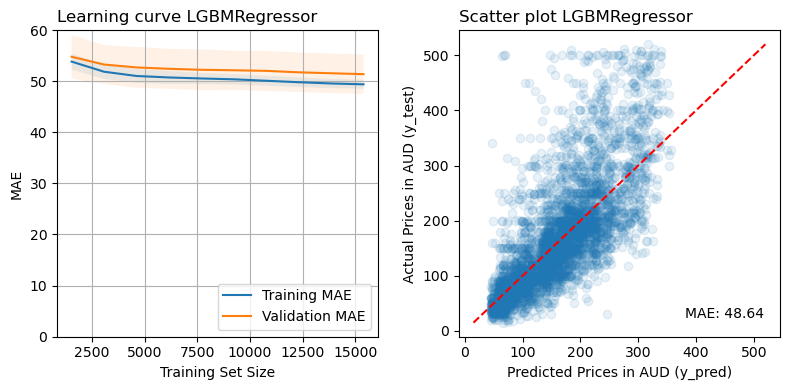

In [81]:
# load data
score_dict = pickle_load('score_dict_learning_curve_dataset_with_feature_selection.pkl')
score_dict = score_dict['LGBMRegressor']
parameters = pickle_load('best_model_dataset_with_feature_selection_parameters.pkl')

# fit and predict the model
y_pred, y_test = fit_predict_lgbm_regressor(list_df[0].drop(columns='price'),
                                                list_df[0]['price'],
                                                parameters)

# plot learning curve and scatter plot
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
plot_learning_curve(score_dict,
                    model_name='LGBMRegressor',
                    idx=0)
scatter_plot_y_pred_y_test(y_pred, y_test,
                           'Scatter plot LGBMRegressor',
                           idx=1)


plt.subplots_adjust(wspace=1.5)
plt.tight_layout()
plt.show()

<a id='learning-curve'></a>**Answer**: It is possible to predict the price of an Airbnb, but the errors of different models vary. Of the models tested, the <mark style="background: #eeeeee!important">LGBMRegressor</mark> is the best model for predicting the price of an Airbnb with an absolute mean error (MAE) of 48.64. This means that the model is on average 48.64 AUD off in predicting the price, which is significant considering the average price is approximately 174 AUD. The scatter plot indicates that the model struggles predicting high-priced Airbnbs.

## <a id='question-2'></a> Question 2: What are the most important features to predict the price of an Airbnb?
### Analysis
I conducted the analysis in the section [feature selection](#feature-selection) using several statistical methods to reduce the number of features in the dataset. This is the result

In [82]:
# load parameters and fit model
parameters = pickle_load('best_model_dataset_with_feature_selection_parameters.pkl')
model = LGBMRegressor(**parameters)
model.fit(list_df[0].drop(columns='price'), list_df[0]['price'])

# create dataframe with feature importance
df_feature_importance = pd.DataFrame({'feature_importance': model.feature_importances_},
                                     index=model.feature_name_)
df_feature_importance.sort_values(by='feature_importance', inplace=True)

### Visualization

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

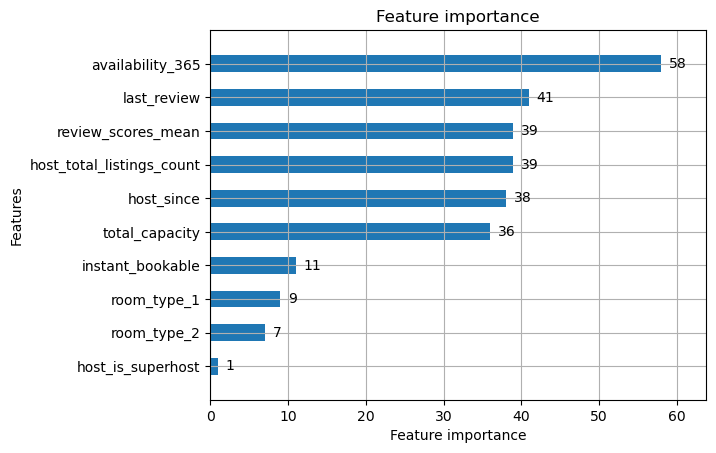

In [83]:
# plotting feature importance
lgbm.plot_importance(model, height=.5)

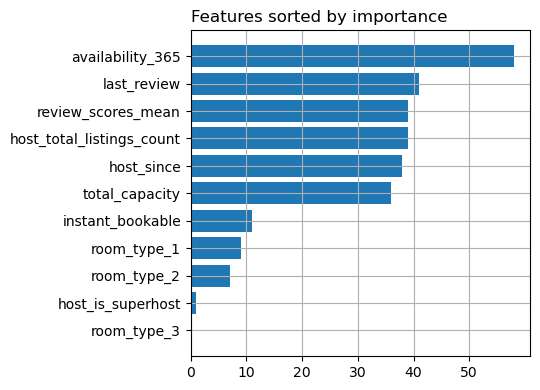

In [87]:
fig, ax = plt.subplots(figsize=(5.5, 4))

ax.barh(df_feature_importance.index, df_feature_importance['feature_importance'])
ax.set_title('Features sorted by importance', loc='left')
ax.set_xticks(np.arange(0, max(df_feature_importance['feature_importance']), 10))
ax.grid()
plt.tight_layout()
plt.show()

**Answer**: Using several statistical methods to select features, the most important features to model the price with the <mark style="background: #eeeeee!important">LGBMRegressor</mark> are illustrated in the figure above. The figure also shows the importance of each feature. Finally, *availability_365*, *last_review*,  *review_scores_mean*, *host_total_listings_count*, *host_since*, and *total_capacity* are the most important features to predict the price, while *instant_bookable*, *room_type* and *host_is_superhost* are of lesser importance. It should be noted that *review_scores_mean* and *total_capacity* are both engineered features that summarize 7 and 2 features, respectively.

## <a id='question-3'></a> Question 3: How many features are necessary to predict the price of an Airbnb? 
### Analysis

In [85]:
# Get Data for the plot
mae_list = []
feature_number_list = []

for i, file_name in enumerate(glob.glob('best*parameters*')):
    # load parameters
    parameters = pickle_load(file_name)

    # fit and predict the model
    y_pred, y_test = fit_predict_lgbm_regressor(list_df[i].drop(columns='price'),
                                                    list_df[i]['price'],
                                                    parameters)
    # append data to lists
    mae_list.append(mean_absolute_error(y_pred, y_test))
    feature_number_list.append(len(list_df[i].columns)-1)
    
categories = ['With\nfeature selection', 'Without\nfeature selection']

### Visualization

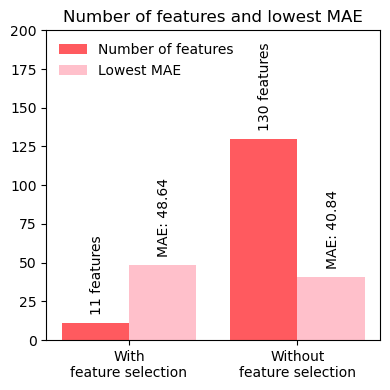

In [86]:
# Create a figure
fig, ax = plt.subplots(figsize=(4, 4))

# Define Airbnb colors
airbnb_blue = '#FF5A5F'
airbnb_red = '#FFC0CB'

# Calculate the x-coordinates for the bars
x = np.arange(len(categories))

# Create a bar plot with Airbnb colors
bar_width = 0.4
ax.bar(x - bar_width/2, feature_number_list, width=bar_width, color=airbnb_blue, label='Number of features')
ax.bar(x + bar_width/2, mae_list, width=bar_width, color=airbnb_red, label='Lowest MAE')

# Add labels to the bars
for i in range(len(categories)):
    feature_number = feature_number_list[i]
    mae = mae_list[i]

    ax.text(x[i] - bar_width/2 + 0.05, feature_number+5,
            f'{feature_number} features',
            ha='right', va='bottom', rotation=90)
    
    ax.text(x[i] + bar_width/2 + 0.05, mae+5,
            f'MAE: {mae:.2f}',
            ha='right', va='bottom', rotation=90)

ax.set_ylim(0,200)
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_title('Number of features and lowest MAE')
ax.legend(frameon=False, loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

**Answer**: Using several statistical methods, it is possible to model the price based on 11 features, compared to a model without feature selection with 130 features. Although the mean absolute error is higher with feature selection, the model performs better than without feature selection, i.e., there is no overfitting as can be seen [here](#learning-curve). The plot is based on a tuned <mark style="background: #eeeeee!important">LGBMRegressor</mark>.

It is likely that it is possible to use fewer features to predict the price of an Airbnbn, probably by simultaneously increasing the model's error. This is the statistically reasonable answer using Pearson's correlation, ϕk correlation, and threshold analysis.